In [1]:
import re
import os, sys
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def getAETrainRes(backgroundType, percent, epoch, modelName, domain):
    dirRes = "../AEresults/{}_{}P_{}E_{}/{}/".format(backgroundType, percent, epoch, modelName, domain)
    fpTest = dirRes + "0-150_test.csv"
    fpTrain = dirRes + "0-150_train.csv"
    fpTime = dirRes + "training_time.csv"
    
    test = pd.read_csv(fpTest)
    train = pd.read_csv(fpTrain)
    time = pd.read_csv(fpTime)
    
    #plotLoss(train, test, percent, epoch, domain, modelName)
    #plotTrainingTime(train, test, percent, domain, modelName)
    return test, train, time

def getTimeDifference(str1, str2):
    time1 = datetime.datetime.strptime(str1, '%H:%M:%S.%f')
    time2 = datetime.datetime.strptime(str2, '%H:%M:%S.%f')
    return (time2 - time1).total_seconds()
    
def getMeanDurationResults(trainAll, testAll, timeAll, percentages, model, domain):
    overallTotalTrain, overallMeanTrain, overallMeanTest = 0, 0, 0
    cases = len(trainAll)
    for idx in range(cases):
        timeMeanTrain = trainAll[idx]['time_epoch(s)'].mean(axis=0)
        timeMeanTest = testAll[idx]['time_epoch(s)'].mean(axis=0)
        totalTrain = getTimeDifference(timeAll[idx]['TrainingStart'][0], timeAll[idx]['TrainingEnd'][0])
        print("Subdomain {} - Model {} - Percent {} - Total Training Time = {} - Mean Training Time = {} and Mean Testing Time = {}".format(domain, model, percentages[idx], totalTrain, timeMeanTrain, timeMeanTest))

        overallMeanTrain += timeMeanTrain
        overallMeanTest += timeMeanTest
        overallTotalTrain += totalTrain
        
    return overallTotalTrain/cases, overallMeanTrain/cases, overallMeanTest/cases

def plotLoss(trainDF, testDF, percent, epoch, domain, modelName):
    epoch_train, err_train = trainDF["epoch"], trainDF["reconstruction_err"]
    plt.plot(epoch_train, err_train, label='train')
    
    epoch_test, err_test = testDF["epoch"], testDF["reconstruction_err"]
    plt.plot(epoch_test, err_test, label='test')
    plt.legend()
    plt.title('Subdomain {} Training with AE for {} Epochs and {}% of locations with model {}.'.format(domain, epoch, percent, modelName))
    plt.savefig('AESubdomain{}{}{}-{}.png'.format(domain, epoch, percent, modelName))
    plt.show()
    
def plotTrainingTime(trainDF, testDF, percent, domain, modelName):
    epoch_train, t_train = trainDF["epoch"],trainDF["time_epoch(s)"]
    epoch_test, t_test = testDF["epoch"], testDF["time_epoch(s)"]
    
    m_train, b_train = np.polyfit(epoch_train, t_train, 1)
    m_test, b_test = np.polyfit(epoch_test, t_test, 1)
    
    plt.plot(epoch_train, t_train, label="train")
    plt.plot(epoch_test, t_test, label="test")
    plt.plot(epoch_train, m_train*epoch_train + b_train, label="train_fit: {:.1f} x + {:.2f}".format(m_train, b_train))
    plt.plot(epoch_test, m_test*epoch_test + b_test, label="test_fit: {:.1f} x + {:.2f}".format(m_test, b_test))
    
    plt.legend()
    plt.title("Subdomain {} Training and Testing Time per Epoch for {}% of locations with model {}.".format(domain, percent, modelName))
    plt.show()
    
def subPlotLoss(trainDF, testDF, percent, epoch, domain, modelName, axes):
    epoch_train, err_train = trainDF["epoch"], trainDF["reconstruction_err"]
    epoch_test, err_test = testDF["epoch"], testDF["reconstruction_err"]
    axes.plot(epoch_train, err_train, label='train')
    axes.plot(epoch_test, err_test, label='test')
    axes.legend(fontsize=25)
    
def subPlotTrainingTime(trainDF, testDF, percent, epoch, domain, modelName, axes):
    epoch_train, t_train = trainDF["epoch"], trainDF["time_epoch(s)"]
    epoch_test, t_test = testDF["epoch"], testDF["time_epoch(s)"]
    
    m_train, b_train = np.polyfit(epoch_train, t_train, 1)
    m_test, b_test = np.polyfit(epoch_test, t_test, 1)
    
    axes.plot(epoch_train, t_train, label="train")
    axes.plot(epoch_test, t_test, label="test")
    axes.plot(epoch_train, m_train*epoch_train + b_train, label="train_fit: {:.1f} x + {:.2f}".format(m_train, b_train))
    axes.plot(epoch_test, m_test*epoch_test + b_test, label="test_fit: {:.1f} x + {:.2f}".format(m_test, b_test))
    axes.legend(fontsize=25)

def getFct(fctName):
    if fctName == "Loss":
        return subPlotLoss
    else:
        return subPlotTrainingTime
    
def createPlots(trainResAll, testResAll, percentages, epoch, domain, modelName, fctName, row, col):
    rows = row
    cols = col
    fig, ax = plt.subplots(rows, cols, sharex = False, sharey = False, figsize = (40, 40))
    
    fct = getFct(fctName)
    print(fct)
    
    for idx in range(len(trainResAll)):
        test = testResAll[idx]
        train = trainResAll[idx]
        pos_x = idx % cols
        pos_y = idx // cols
        if idx % 2 == 0:
            loss='L1'
        else:
            loss='L2'
        axes = ax[pos_y, pos_x]
        fct(train, test, percentages[idx], epoch, domain, modelName, axes)
        axes.set_title("Domain {}, {}% Locations, Model {}.".format(domain, percentages[idx], modelName), fontsize=50)
        axes.set_xlabel('Epoch', fontsize=30)
        axes.set_ylabel(loss, fontsize=40)
    fig.savefig('AETraining{}-{}{}{}.'.format(fctName, domain, epoch, modelName))
    fig.show()

## 1D - 2 Linear Layers

Subdomain 8 - Model 1D2L - Percent 10 - Total Training Time = 97.878421 - Mean Training Time = 0.5973118257522583 and Mean Testing Time = 0.16219741106033325
Subdomain 8 - Model 1D2L - Percent 20 - Total Training Time = 113.510994 - Mean Training Time = 0.6913966798782348 and Mean Testing Time = 0.1721808910369873
Subdomain 8 - Model 1D2L - Percent 40 - Total Training Time = 109.53847 - Mean Training Time = 0.6668856493631998 and Mean Testing Time = 0.17863936722278595
Subdomain 8 - Model 1D2L - Percent 50 - Total Training Time = 115.672298 - Mean Training Time = 0.7084739065170288 and Mean Testing Time = 0.17712509632110596
Subdomain 8 - Model 1D2L - Percent 60 - Total Training Time = 117.731507 - Mean Training Time = 0.7182244269053141 and Mean Testing Time = 0.18074895441532135
Subdomain 8 - Model 1D2L - Percent 70 - Total Training Time = 113.749339 - Mean Training Time = 0.6923008791605632 and Mean Testing Time = 0.1792527735233307
Subdomain 8 - Model 1D2L - Percent 80 - Total Trai

<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10a106af0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


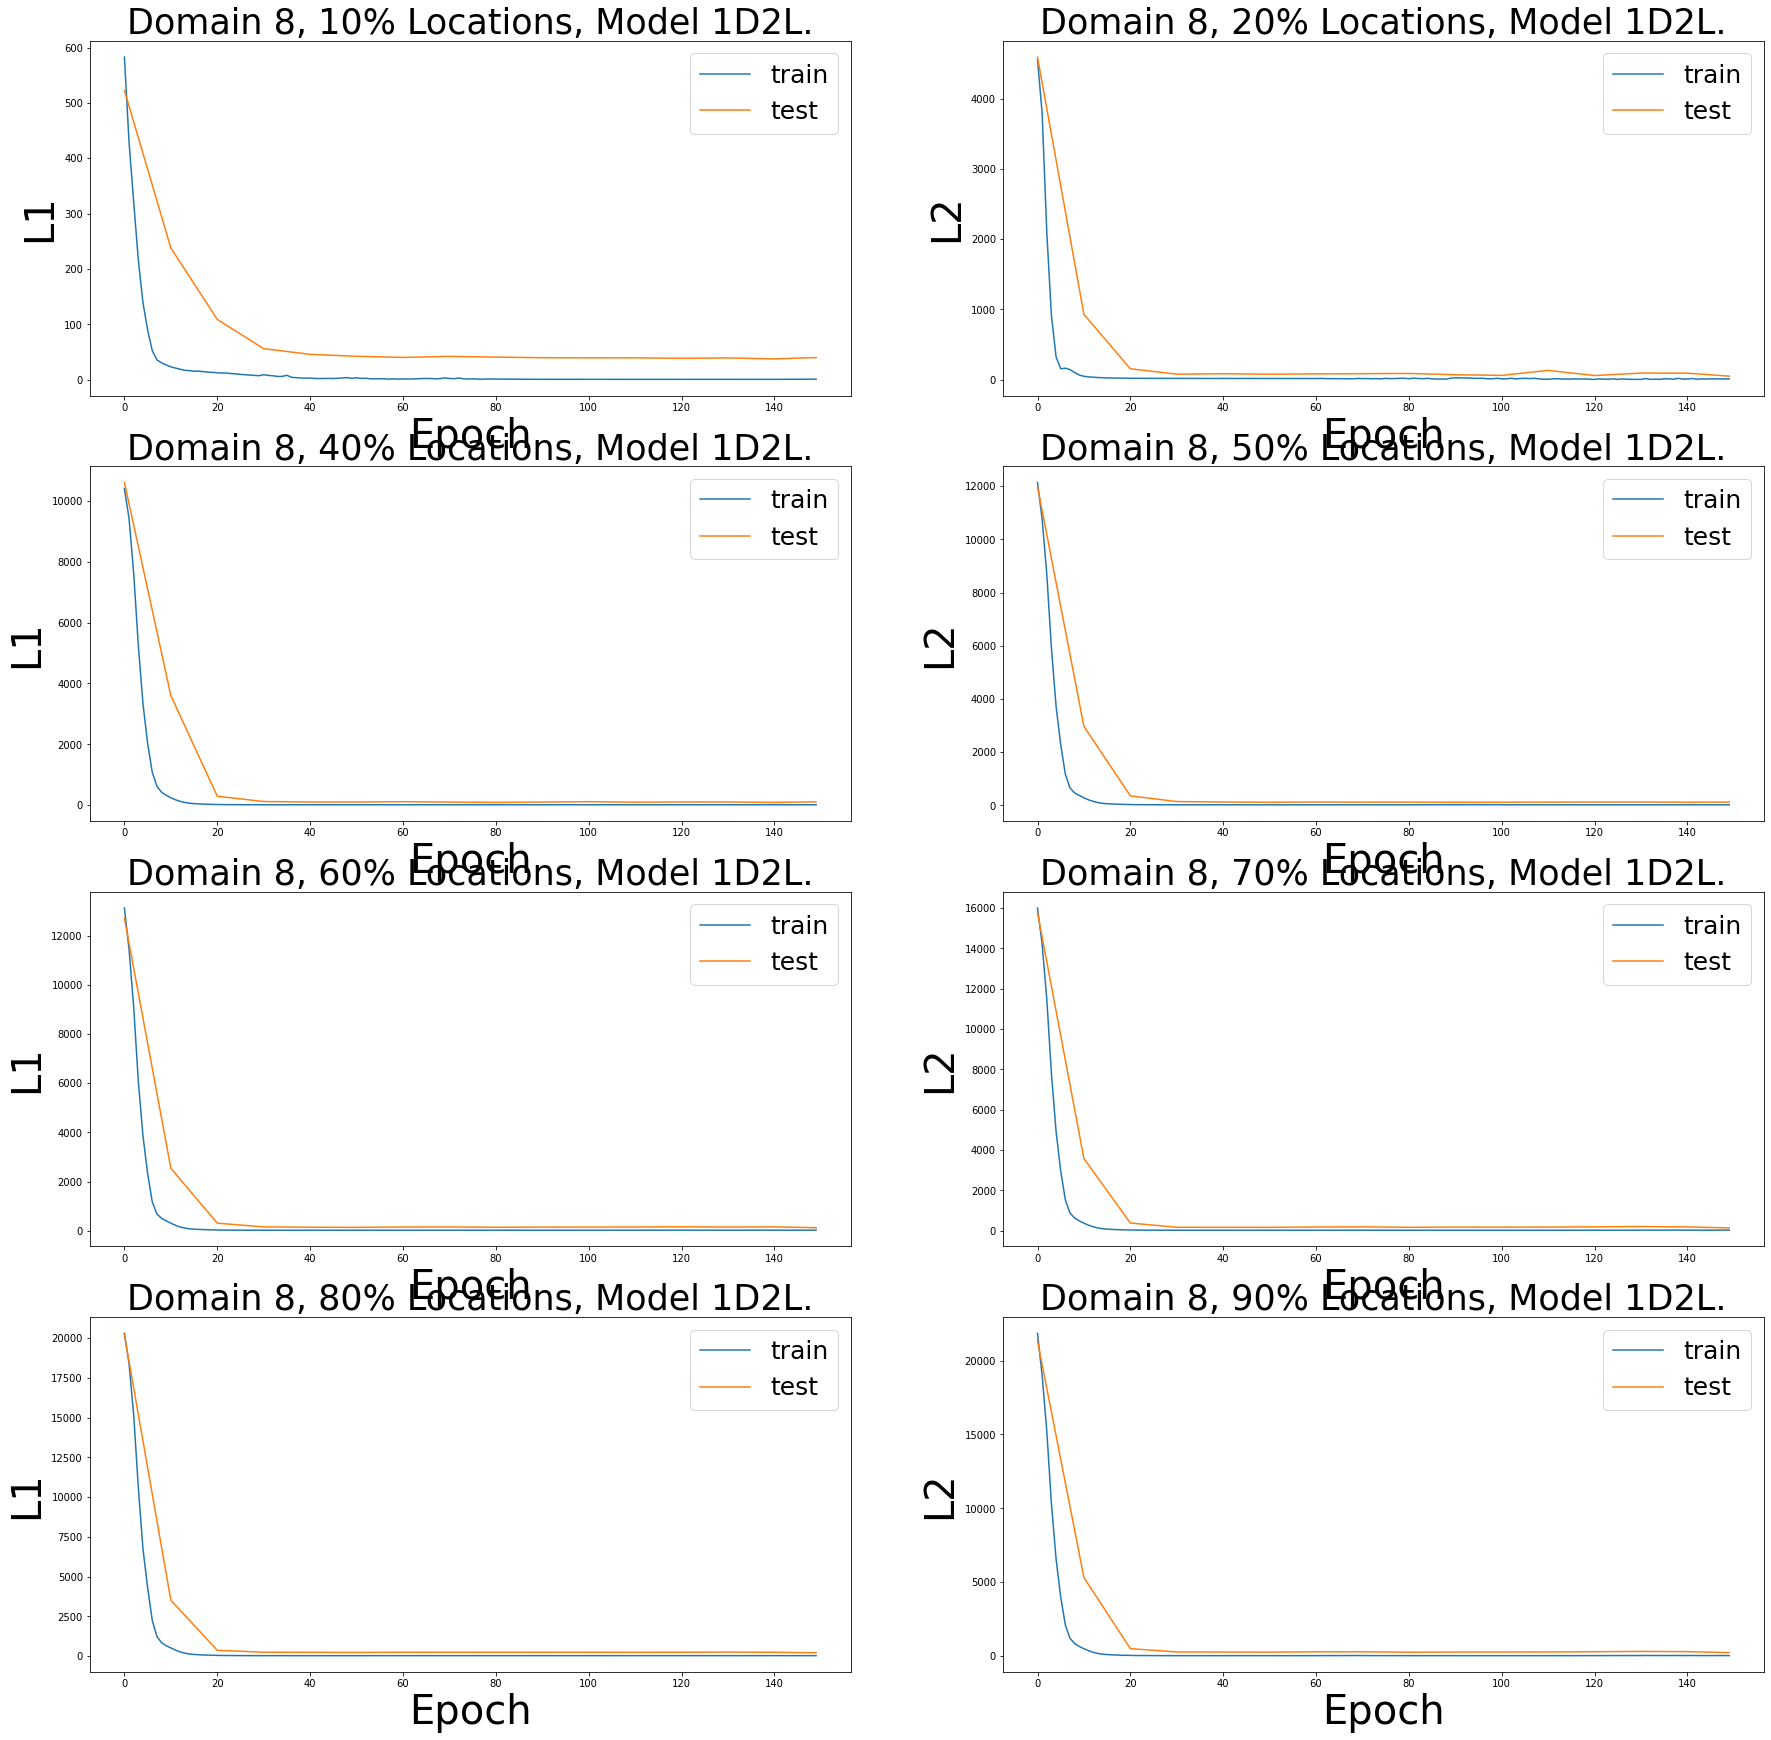

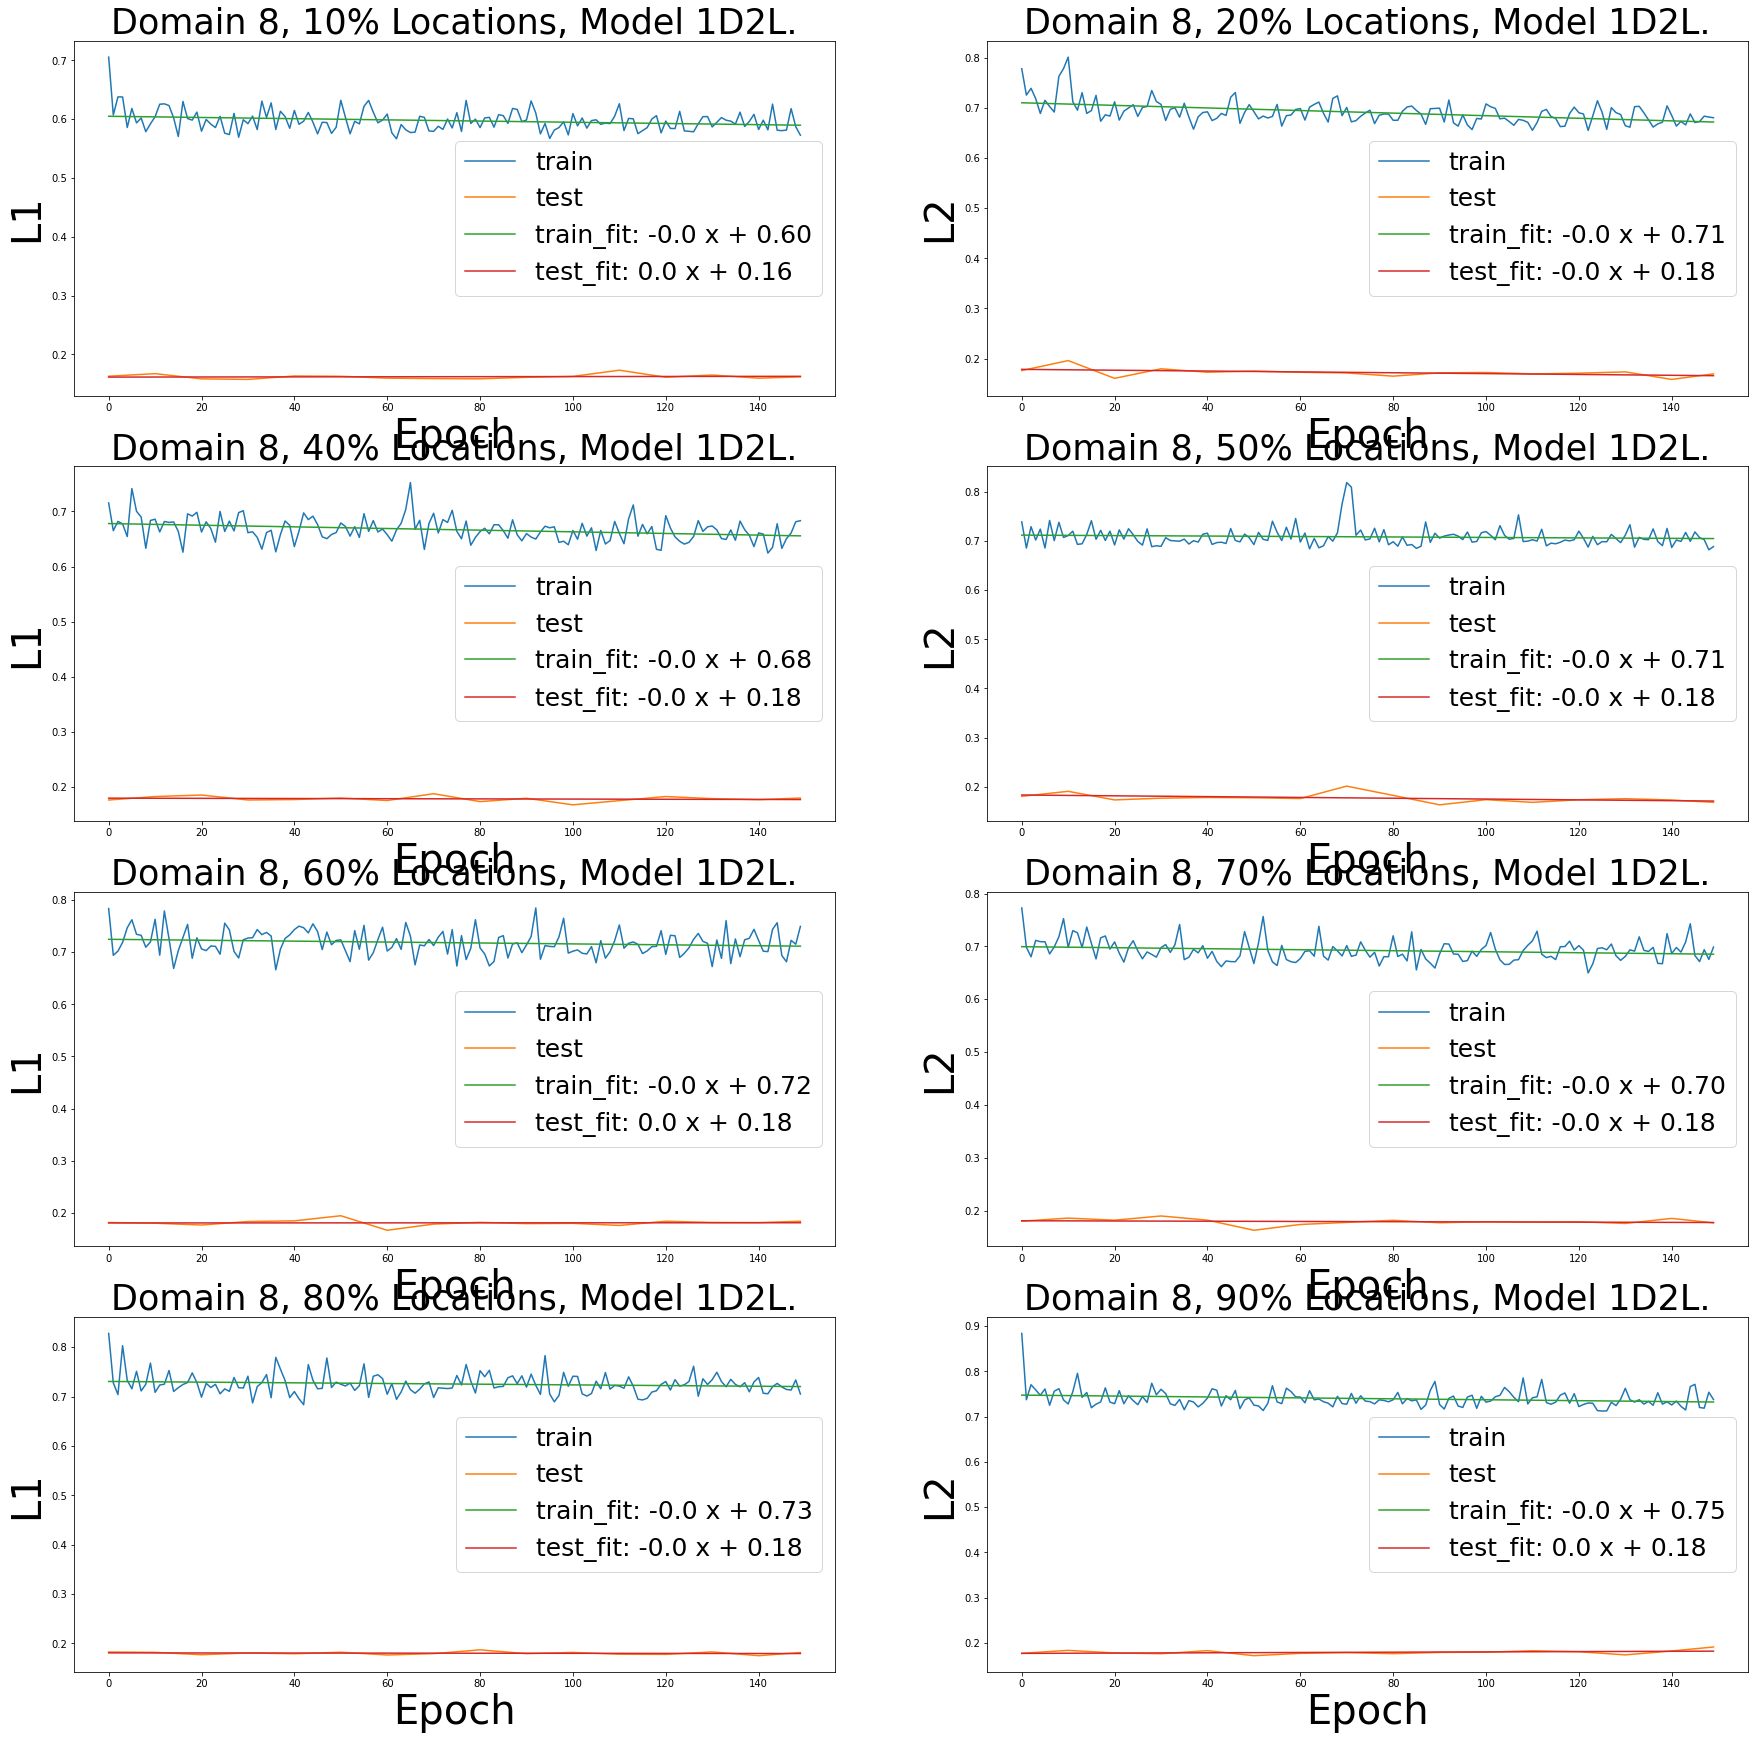

In [32]:
test8_10, train8_10, time8_10 = getAETrainRes("MeanHist", 10, 150, "1D2L", 8)
test8_20, train8_20, time8_20 = getAETrainRes("MeanHist", 20, 150, "1D2L", 8)
test8_40, train8_40, time8_40 = getAETrainRes("MeanHist", 40, 150, "1D2L", 8)
test8_50, train8_50, time8_50 = getAETrainRes("MeanHist", 50, 150, "1D2L", 8)
test8_60, train8_60, time8_60 = getAETrainRes("MeanHist", 60, 150, "1D2L", 8)
test8_70, train8_70, time8_70 = getAETrainRes("MeanHist", 70, 150, "1D2L", 8)
test8_80, train8_80, time8_80 = getAETrainRes("MeanHist", 80, 150, "1D2L", 8)
test8_90, train8_90, time8_90 = getAETrainRes("MeanHist", 90, 150, "1D2L", 8)

trainResAll = [train8_10, train8_20, train8_40, train8_50, train8_60, train8_70, train8_80, train8_90]
testResAll = [test8_10, test8_20, test8_40, test8_50, test8_60, test8_70, test8_80, test8_90]
timeAll = [time8_10, time8_20, time8_40, time8_50, time8_60, time8_70, time8_80, time8_90]
percentages = [10, 20, 40, 50, 60, 70, 80, 90]
EPOCH = 150

totalDuration, totalTrainingTime, totalTestingTime = getMeanDurationResults(trainResAll, testResAll, timeAll, percentages, "1D2L", "8")
print("Mean Total Training Duration = {}, Time per Epoch = {}, Mean Train Duration = {}, Mean Testing Duration = {}".format(totalDuration, totalDuration / EPOCH, totalTrainingTime, totalTestingTime))
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D2L", "Loss", 4, 2)
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D2L", "Time", 4, 2)

In [33]:
test6_40, train6_40, time6_40 = getAETrainRes("MeanHist", 40, 150, "1D4L", 6)

Subdomain 8 - Model 1D2L - Percent 20 - Total Training Time = 97.878421 - Mean Training Time = 0.6723879766464234 and Mean Testing Time = 0.16380932927131653
Subdomain 8 - Model 1D2L - Percent 40 - Total Training Time = 113.510994 - Mean Training Time = 0.8508242623011271 and Mean Testing Time = 0.18713997304439545
Mean Total Training Duration = 105.69470749999999, Time per Epoch = 0.7046313833333333, Mean Train Duration = 0.7616061194737752, Mean Testing Duration = 0.175474651157856
<function subPlotLoss at 0x10a1065e0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10a106af0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


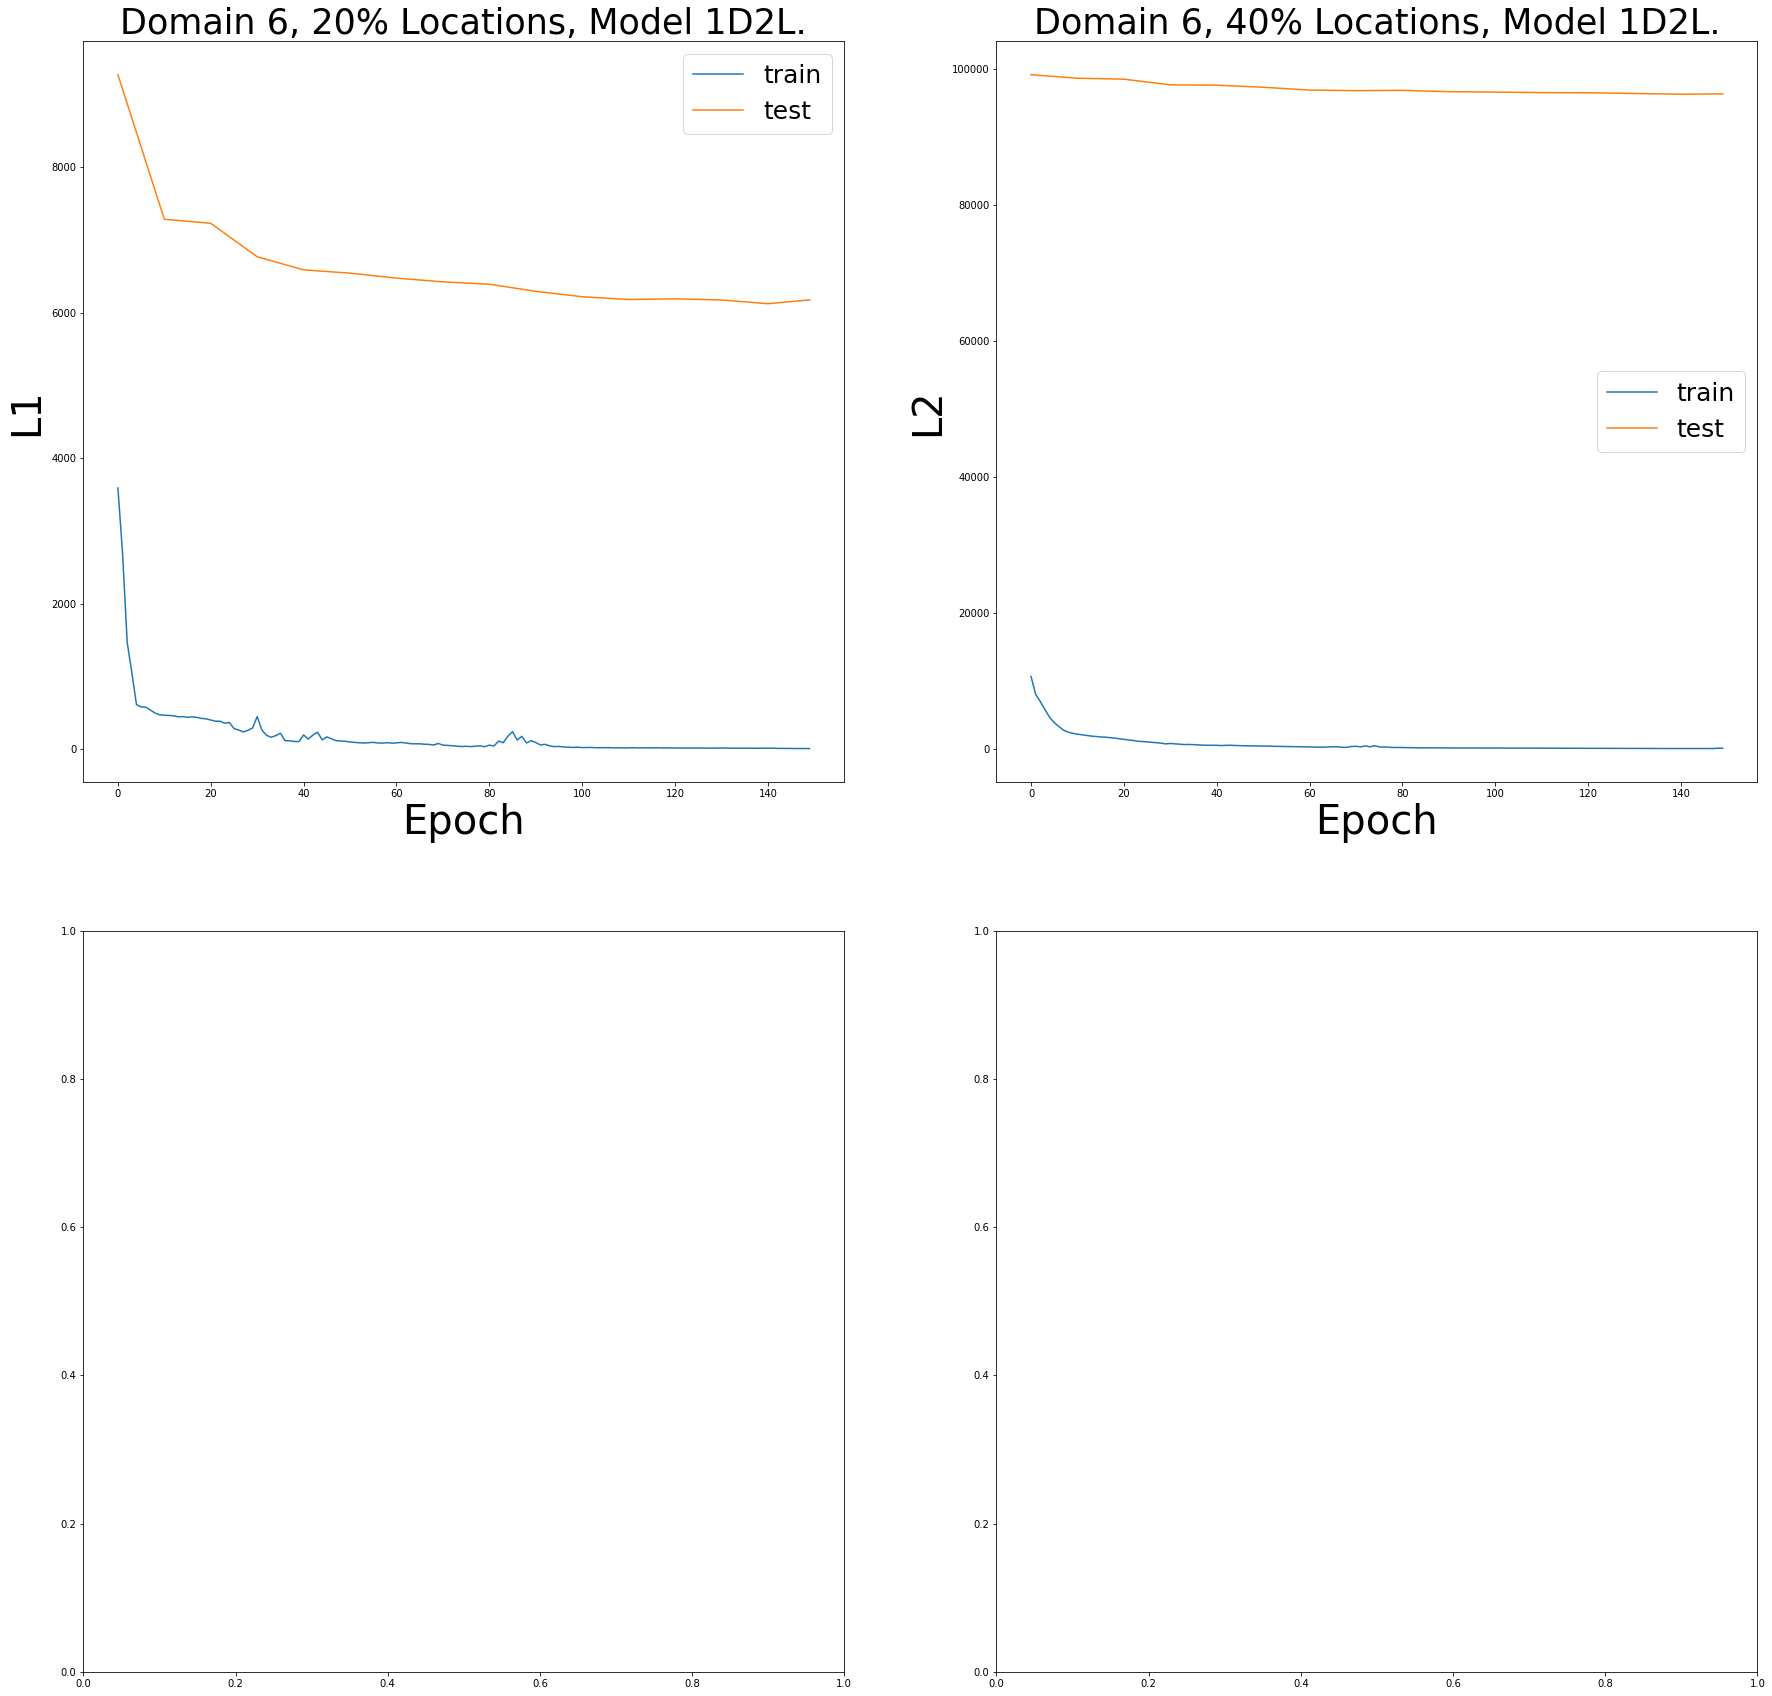

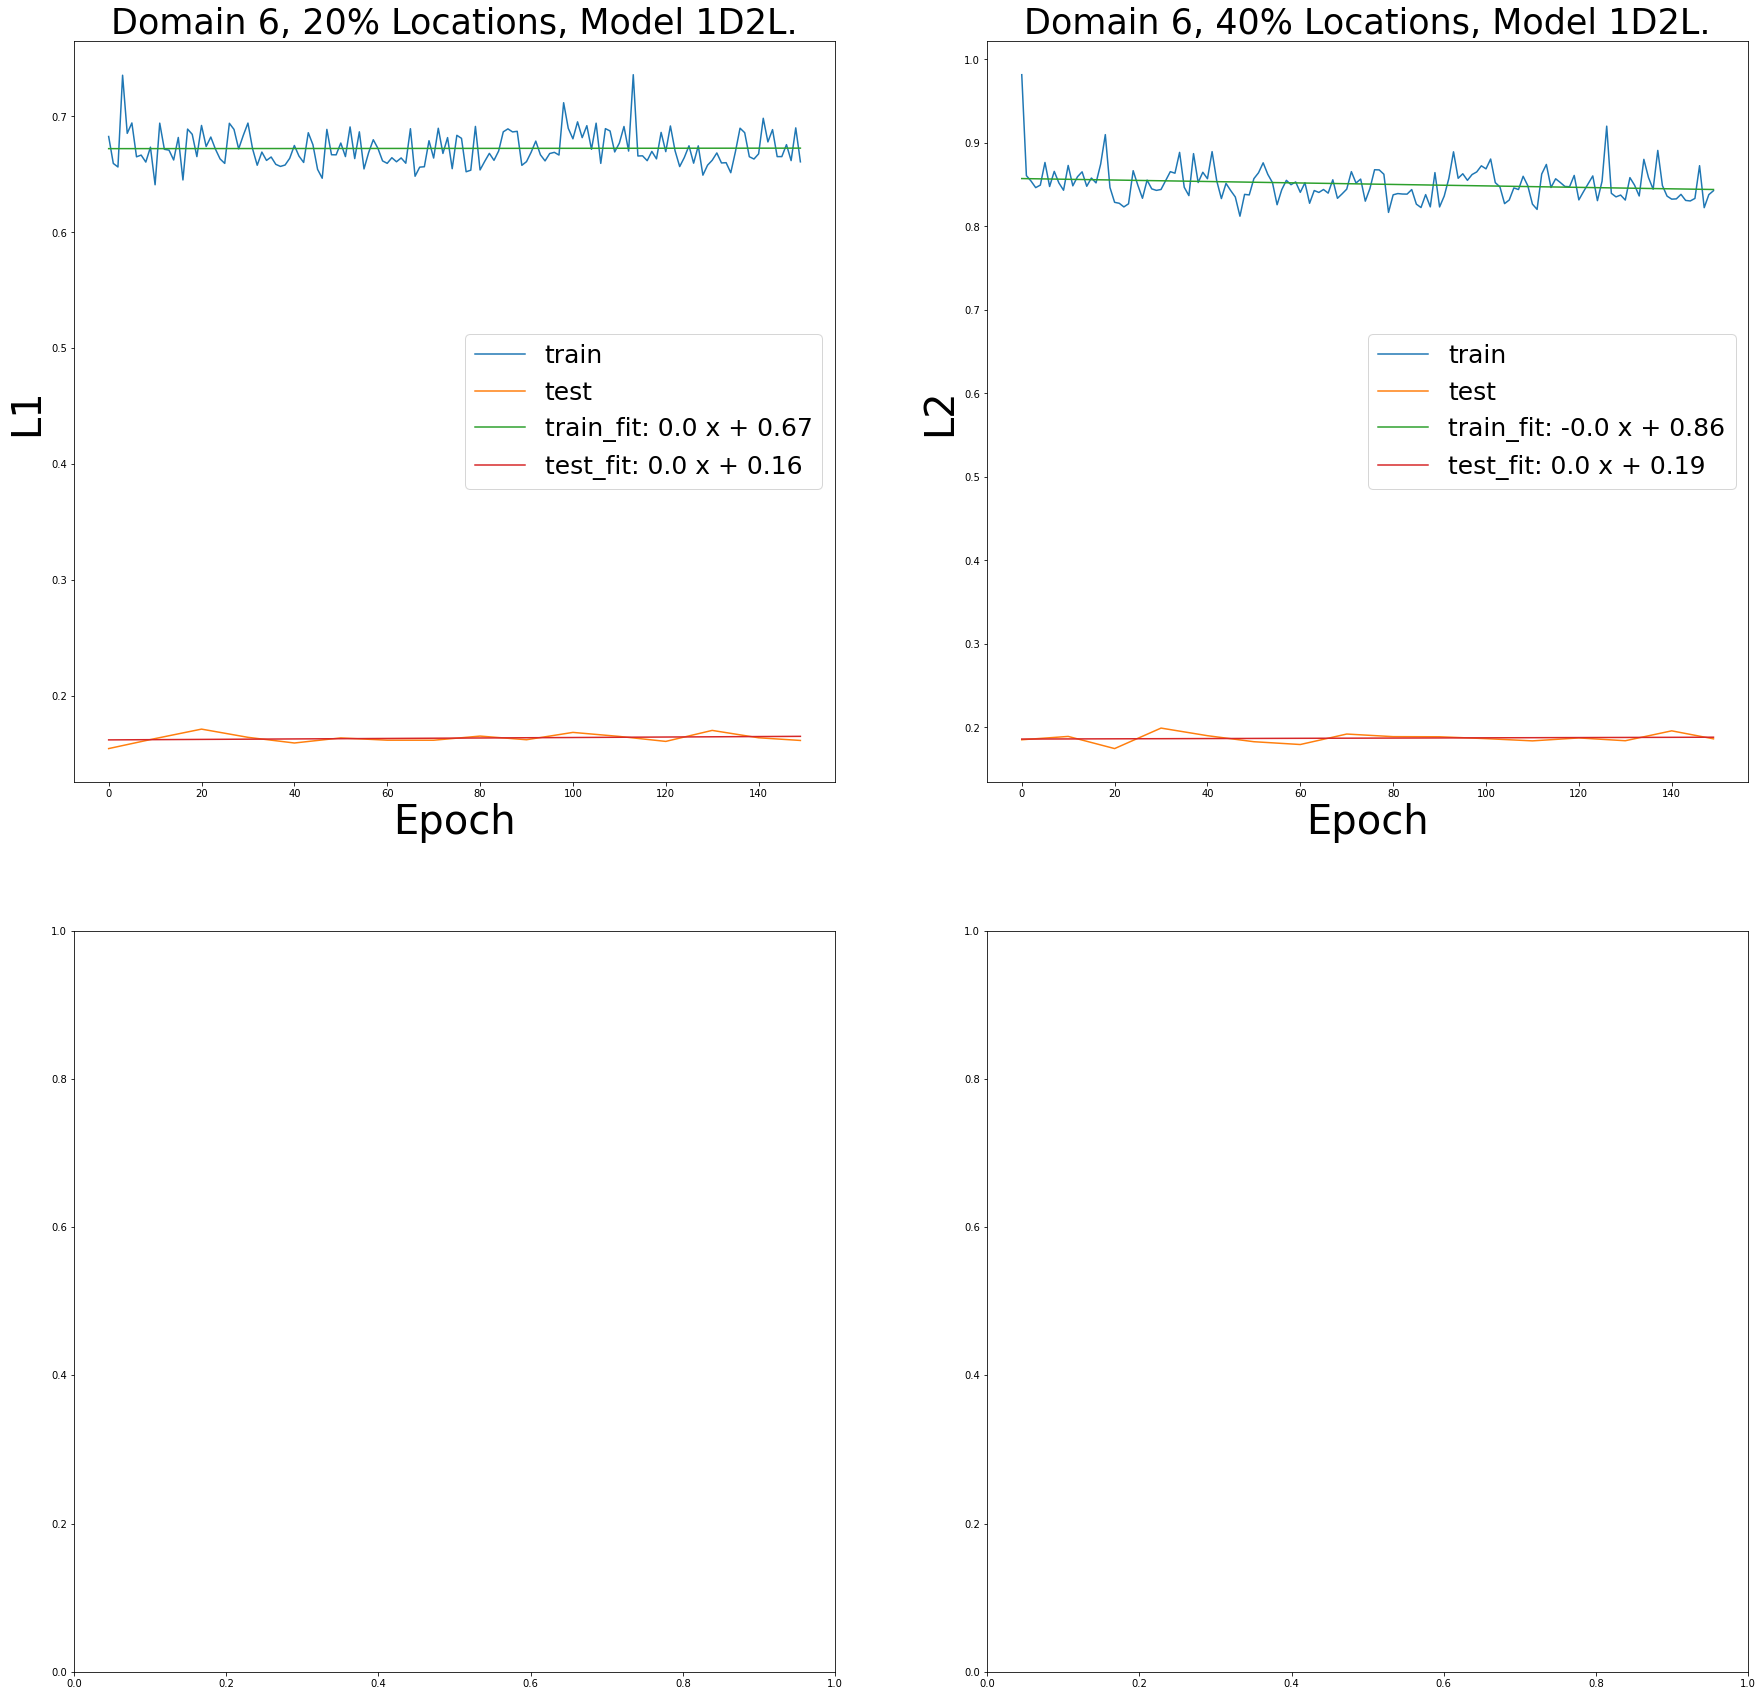

In [35]:
test6_40, train6_40, time6_40 = getAETrainRes("MeanHist", 40, 150, "1D2L", 6)
test6_20, train6_20, time6_20 = getAETrainRes("MeanHist", 20, 150, "1D2L", 6)

trainResAll = [train6_20, train6_40]
testResAll = [test6_20, test6_40]
timeall = [time6_20, time6_40]
percentages = [20, 40]
EPOCH = 150

totalDuration, totalTrainingTime, totalTestingTime = getMeanDurationResults(trainResAll, testResAll, timeAll, percentages, "1D2L", "8")
print("Mean Total Training Duration = {}, Time per Epoch = {}, Mean Train Duration = {}, Mean Testing Duration = {}".format(totalDuration, totalDuration / EPOCH, totalTrainingTime, totalTestingTime))
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D2L", "Loss", 2, 2)
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D2L", "Time", 2, 2)

# Evaluating Loss function

<function subPlotLoss at 0x11e6e49d0>


<ipython-input-52-36a6281f0478>:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x11e6e4940>


<ipython-input-52-36a6281f0478>:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


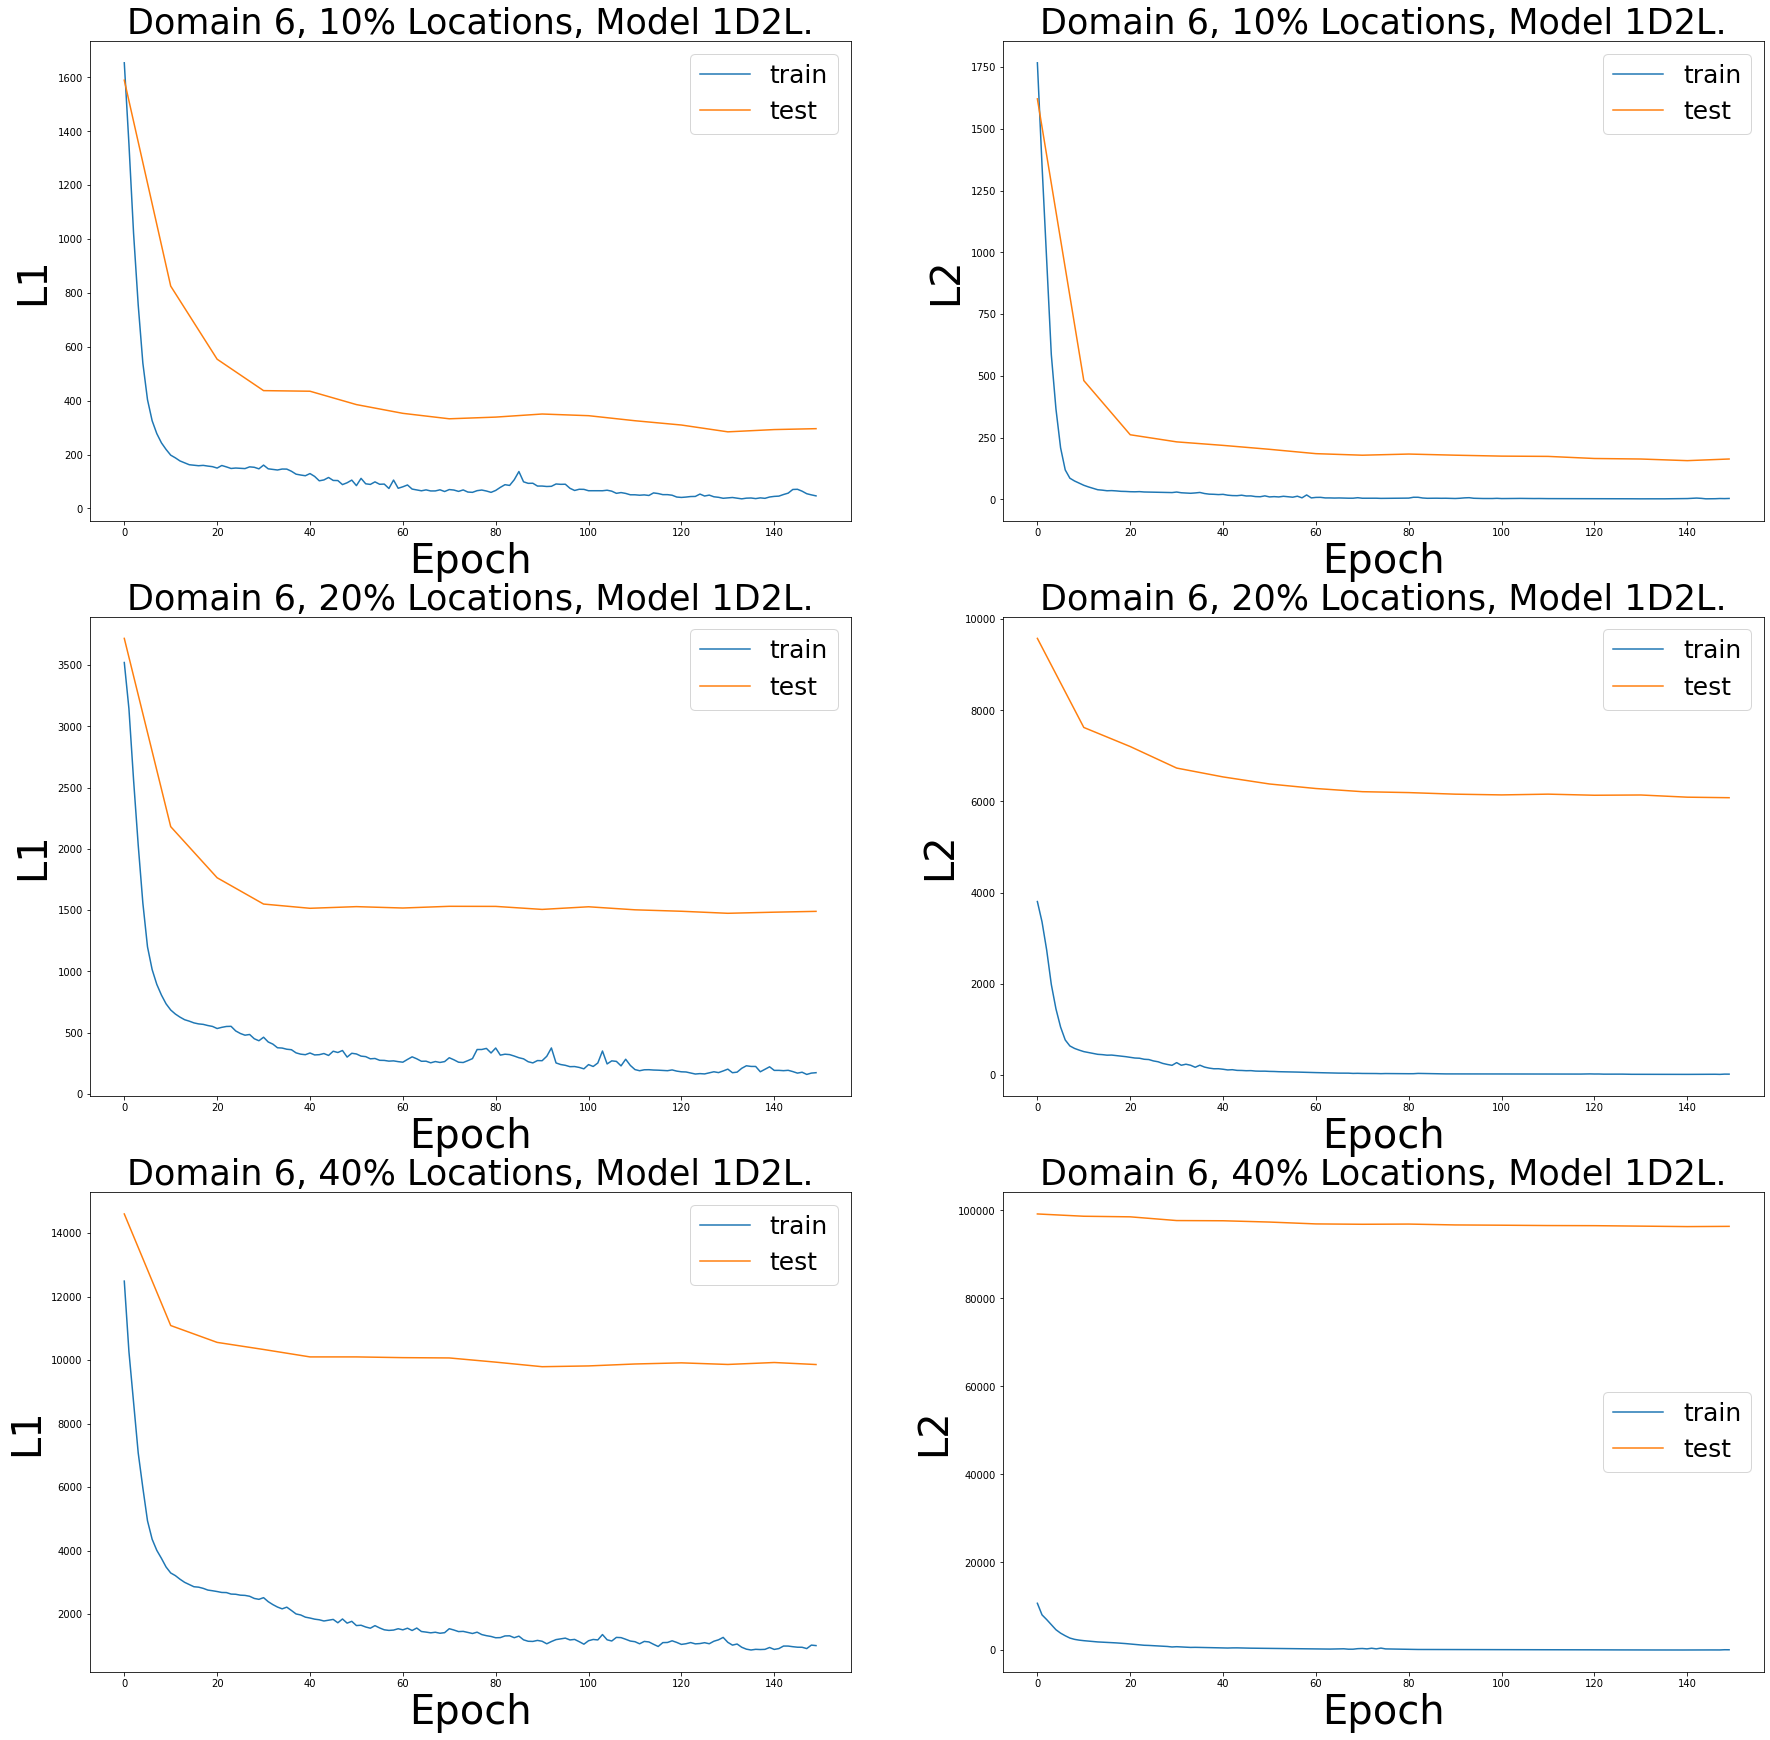

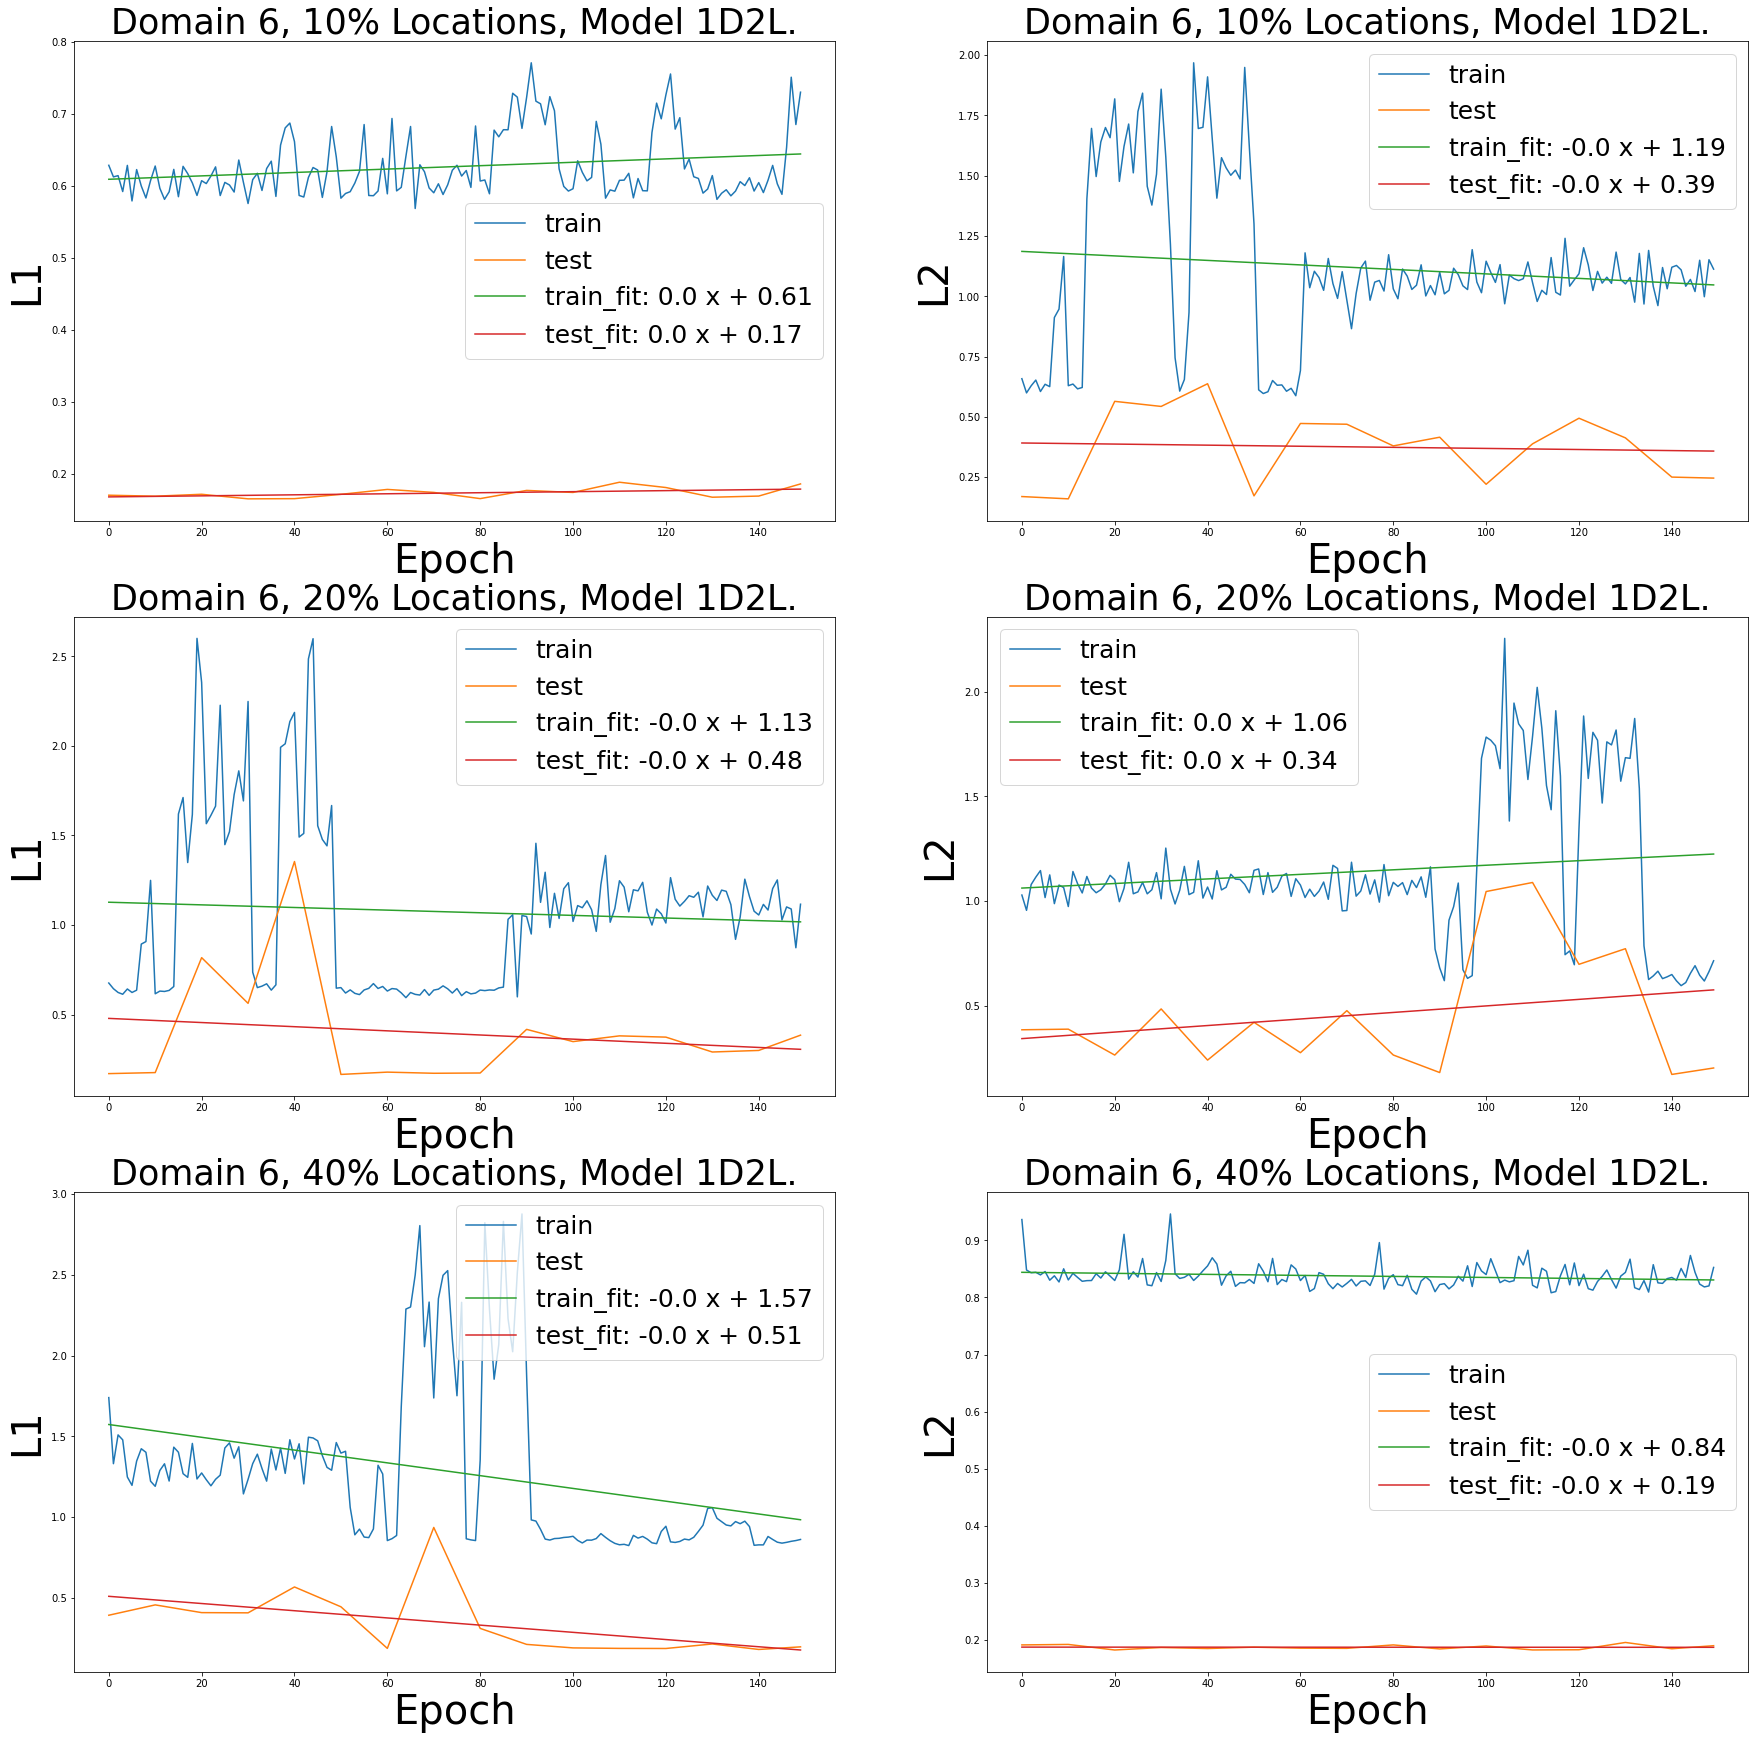

In [53]:
test6_10_L1, train6_10_L1, time6_10_L1 = getAETrainRes("IdxL1", 10, 150, "1D2L", 6)
test6_20_L1, train6_20_L1, time6_20_L1 = getAETrainRes("IdxL1", 20, 150, "1D2L", 6)
test6_40_L1, train6_40_L1, time6_40_L1 = getAETrainRes("IdxL1", 40, 150, "1D2L", 6)

test6_10, train6_10, time6_10 = getAETrainRes("Idx", 10, 150, "1D2L", 6)
test6_20, train6_20, time6_20 = getAETrainRes("Idx", 20, 150, "1D2L", 6)
test6_40, train6_40, time6_40 = getAETrainRes("Idx", 40, 150, "1D2L", 6)

trainResAll = [train6_10_L1, train6_10, train6_20_L1, train6_20, train6_40_L1, train6_40]
testResAll = [test6_10_L1, test6_10, test6_20_L1, test6_20, test6_40_L1, test6_40]
percentages = [10, 10, 20, 20, 40, 40]

createPlots(trainResAll, testResAll, percentages, "150", "6", "1D2L", "Loss", 3, 2)
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D2L", "Time", 3, 2)

<function subPlotLoss at 0x10406a790>


<ipython-input-3-423e8c655113>:111: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10e0cc820>


<ipython-input-3-423e8c655113>:111: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


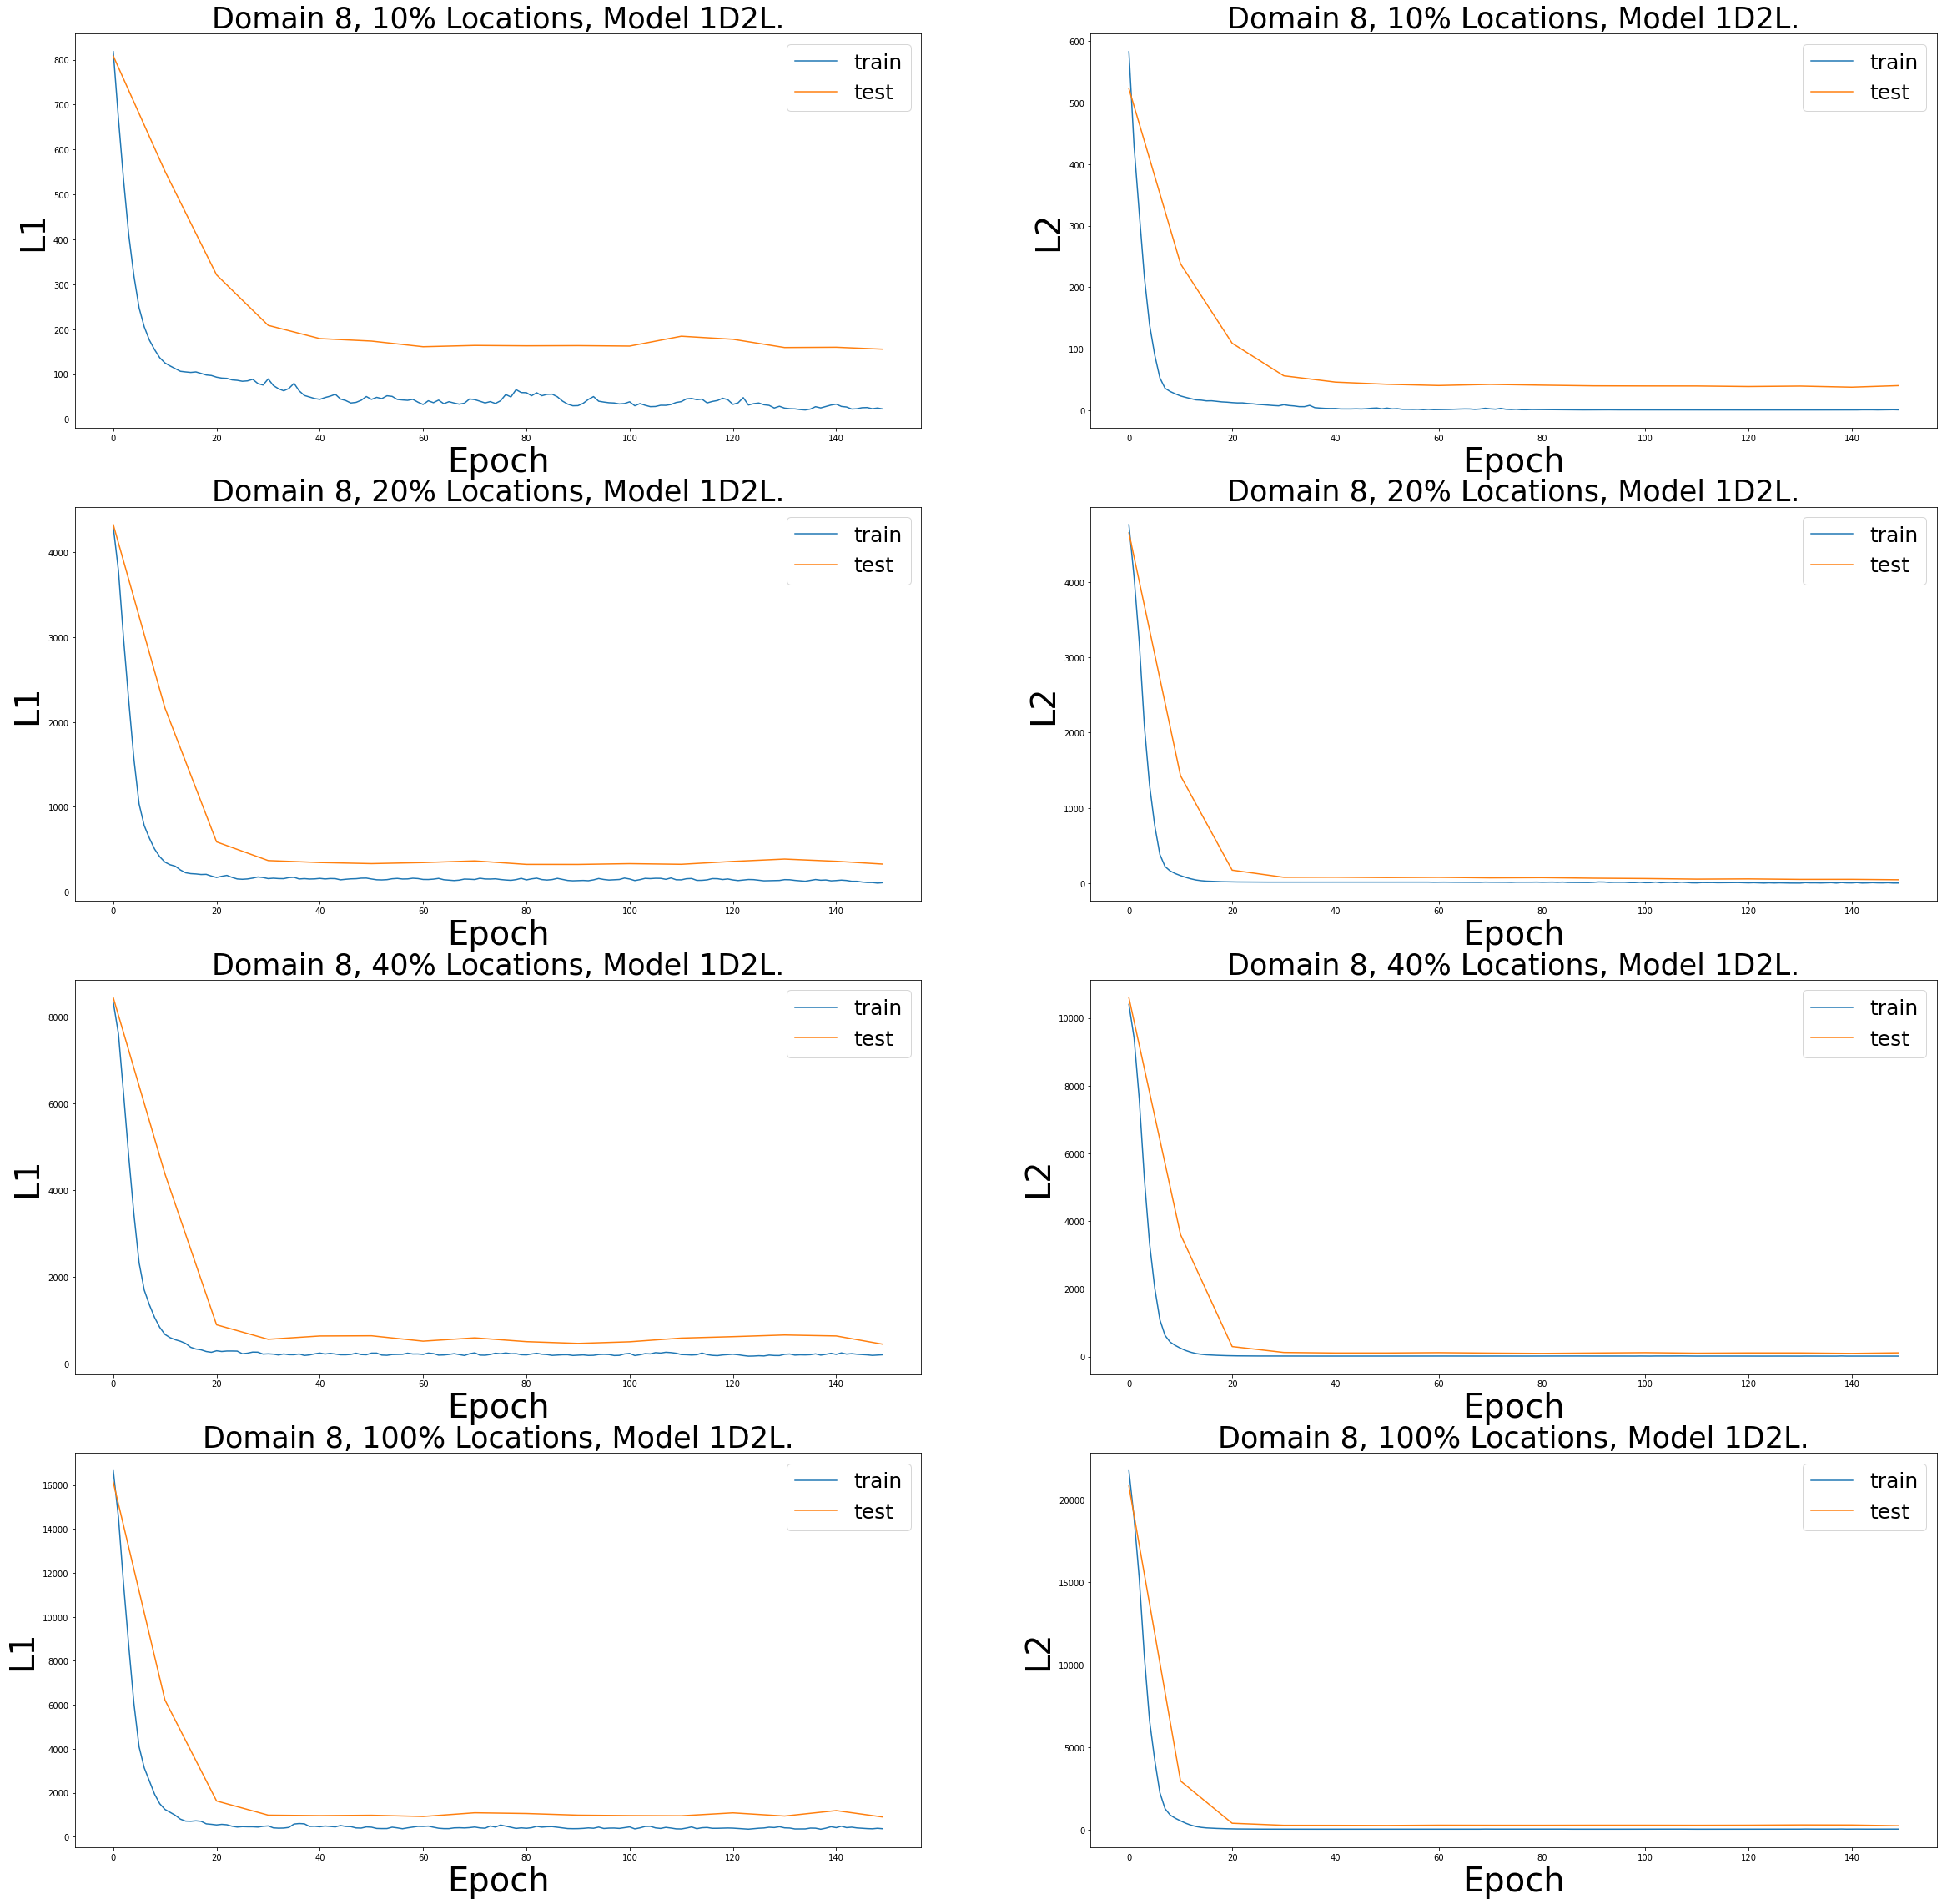

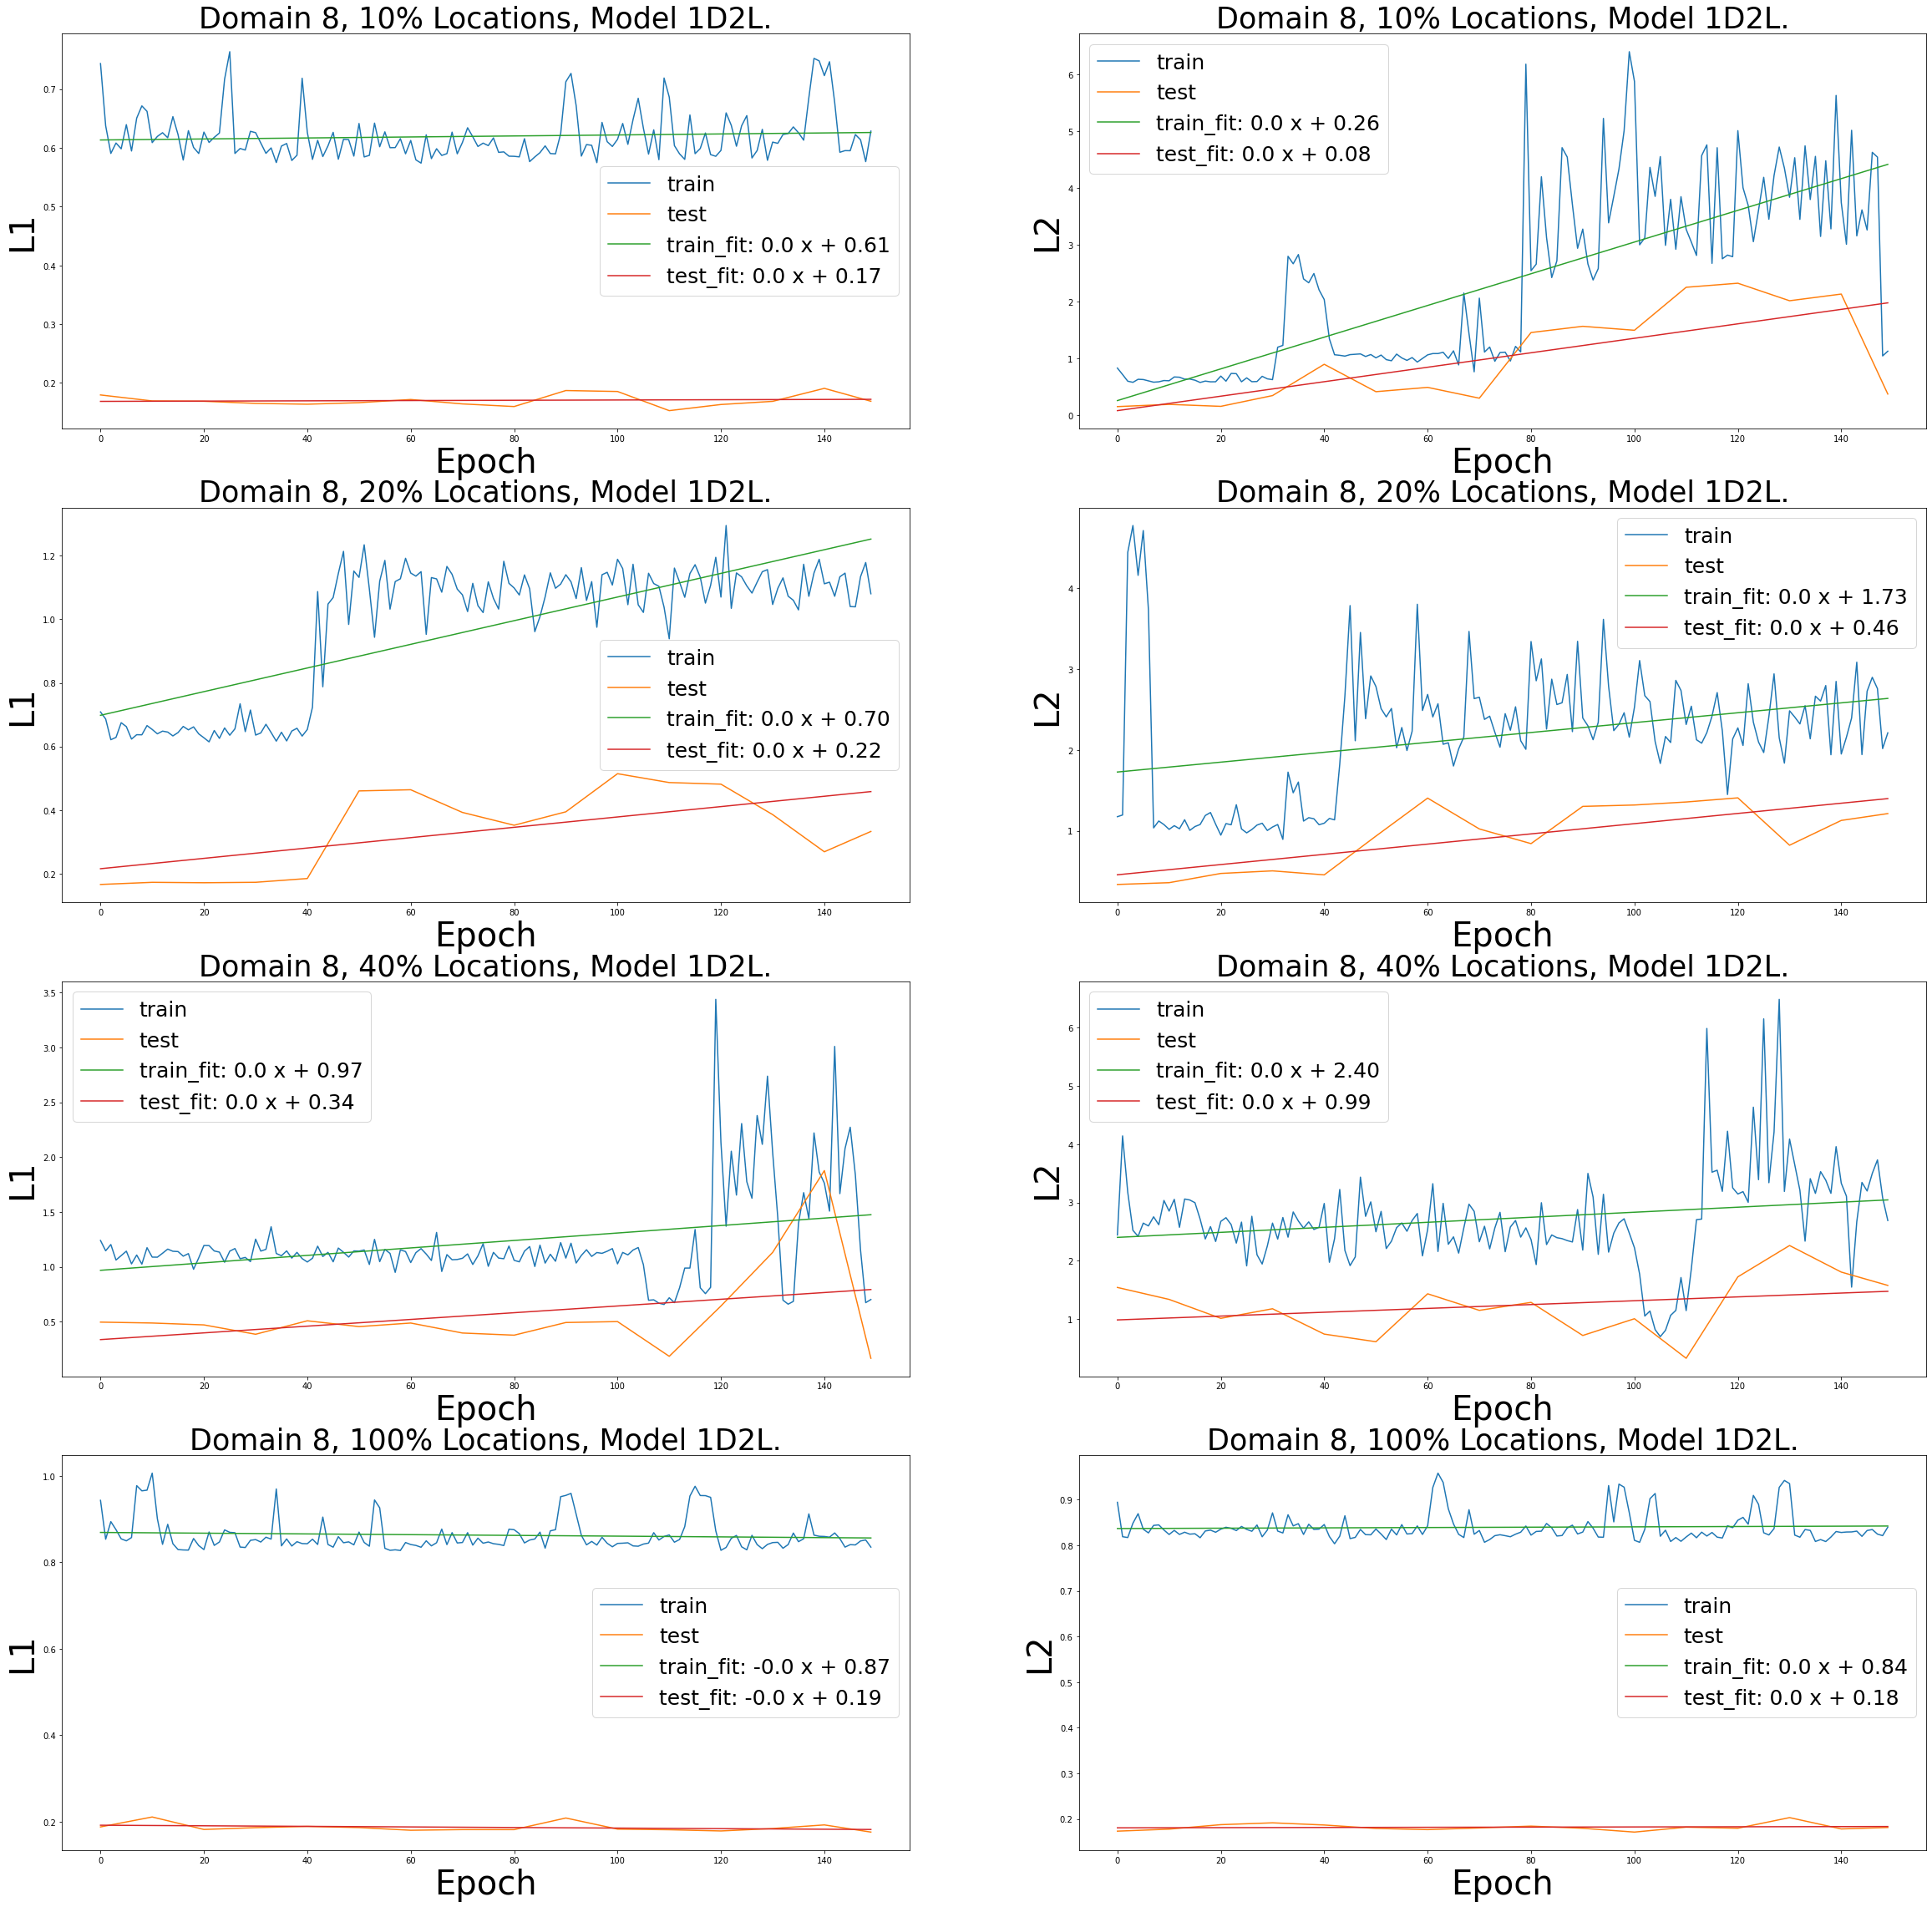

In [4]:
test8_10_L1, train8_10_L1, time8_10_L1 = getAETrainRes("IdxL1", 10, 150, "1D2L", 8)
test8_20_L1, train8_20_L1, time8_20_L1 = getAETrainRes("IdxL1", 20, 150, "1D2L", 8)
test8_40_L1, train8_40_L1, time8_40_L1 = getAETrainRes("IdxL1", 40, 150, "1D2L", 8)
test8_100_L1, train8_100_L1, time8_100_L1 = getAETrainRes("IdxL1", 100, 150, "1D2L", 8)

test8_10, train8_10, time8_10 = getAETrainRes("Idx", 10, 150, "1D2L", 8)
test8_20, train8_20, time8_20 = getAETrainRes("Idx", 20, 150, "1D2L", 8)
test8_40, train8_40, time8_40 = getAETrainRes("Idx", 40, 150, "1D2L", 8)
test8_100, train8_100, time8_100 = getAETrainRes("Idx", 100, 150, "1D2L", 8)

trainResAll = [train8_10_L1, train8_10, train8_20_L1, train8_20, train8_40_L1, train8_40, train8_100_L1, train8_100]
testResAll = [test8_10_L1, test8_10, test8_20_L1, test8_20, test8_40_L1, test8_40, test8_100_L1, test8_100]
percentages = [10, 10, 20, 20, 40, 40, 100, 100]

createPlots(trainResAll, testResAll, percentages, "150", "8", "1D2L", "Loss", 4, 2)
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D2L", "Time", 4, 2)

# 1D - 4 Linear Layers

Subdomain 8 - Model 1D4L - Percent 10 - Total Training Time = 97.941811 - Mean Training Time = 0.5956394608815511 and Mean Testing Time = 0.15563015639781952
Subdomain 8 - Model 1D4L - Percent 20 - Total Training Time = 110.607859 - Mean Training Time = 0.6719747861226399 and Mean Testing Time = 0.16812454164028168
Subdomain 8 - Model 1D4L - Percent 40 - Total Training Time = 136.617998 - Mean Training Time = 0.8385853052139283 and Mean Testing Time = 0.16870254278182983
Subdomain 8 - Model 1D4L - Percent 80 - Total Training Time = 178.75257 - Mean Training Time = 1.104870621363322 and Mean Testing Time = 0.1853541135787964
Mean Total Training Duration = 130.98005949999998, Time per Epoch = 0.8732003966666665, Mean Train Duration = 0.8027675433953603, Mean Testing Duration = 0.16945283859968185
<function subPlotLoss at 0x10a1065e0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10a106af0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Subdomain 6 - Model 1D4L - Percent 10 - Total Training Time = 97.941811 - Mean Training Time = 0.6025002876917521 and Mean Testing Time = 0.1563407927751541
Subdomain 6 - Model 1D4L - Percent 20 - Total Training Time = 110.607859 - Mean Training Time = 0.6592102861404419 and Mean Testing Time = 0.1641719490289688
Subdomain 6 - Model 1D4L - Percent 40 - Total Training Time = 136.617998 - Mean Training Time = 1.404817837079366 and Mean Testing Time = 0.19472815096378326
Mean Total Training Duration = 115.05588933333333, Time per Epoch = 0.7670392622222222, Mean Train Duration = 0.8888428036371868, Mean Testing Duration = 0.17174696425596872
<function subPlotLoss at 0x10a1065e0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10a106af0>


<ipython-input-31-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


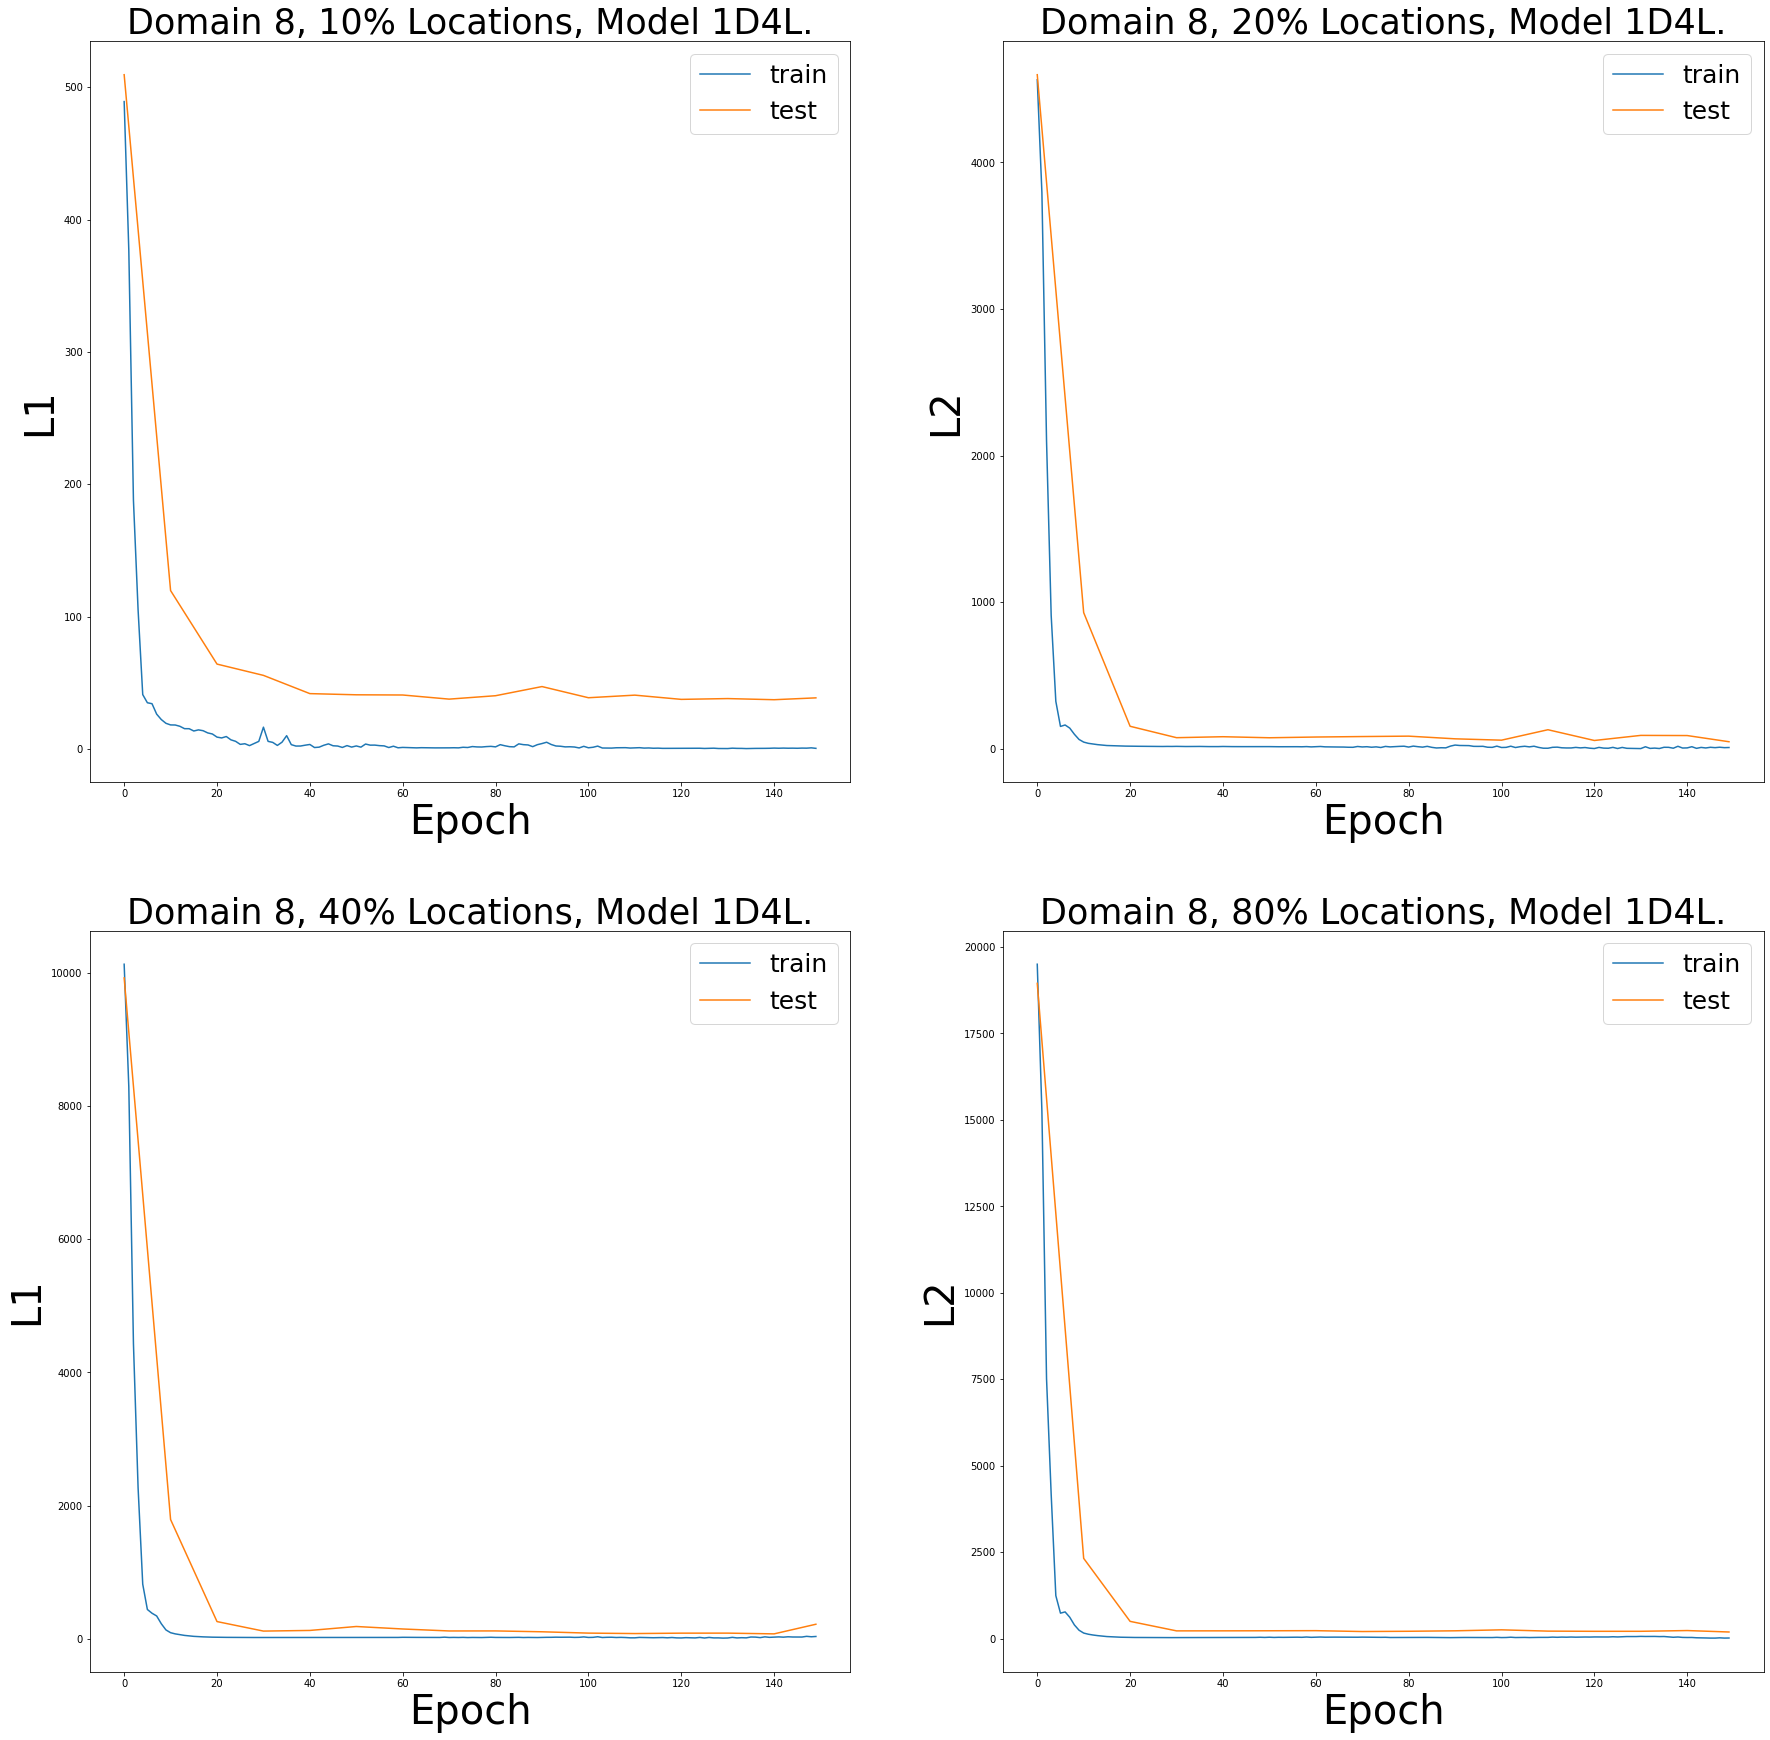

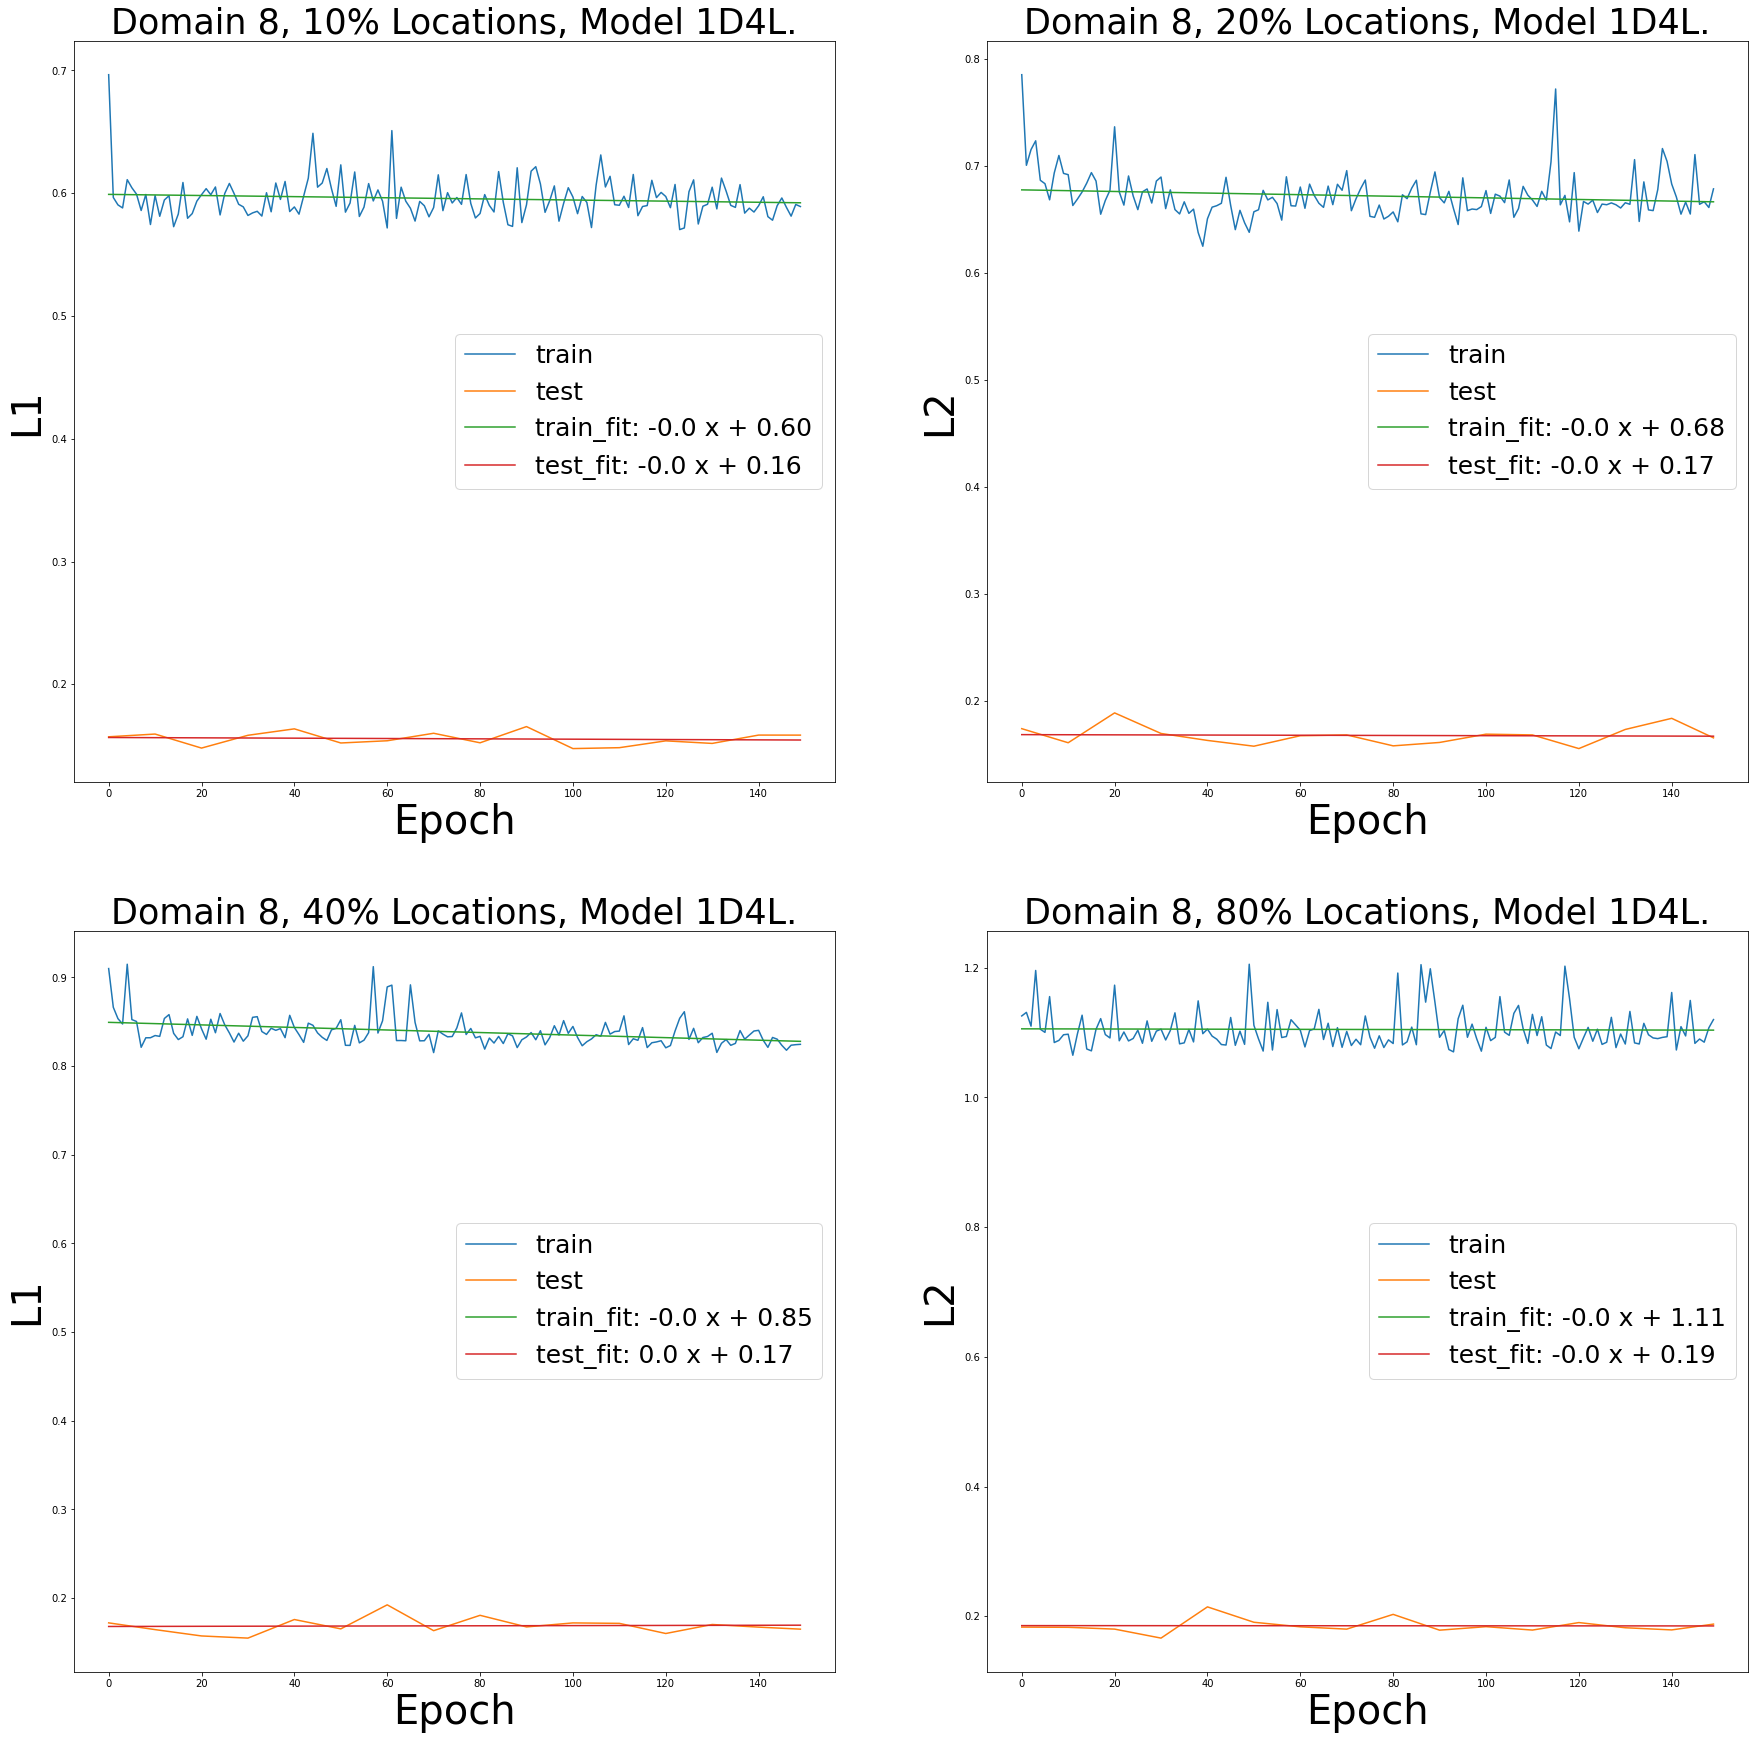

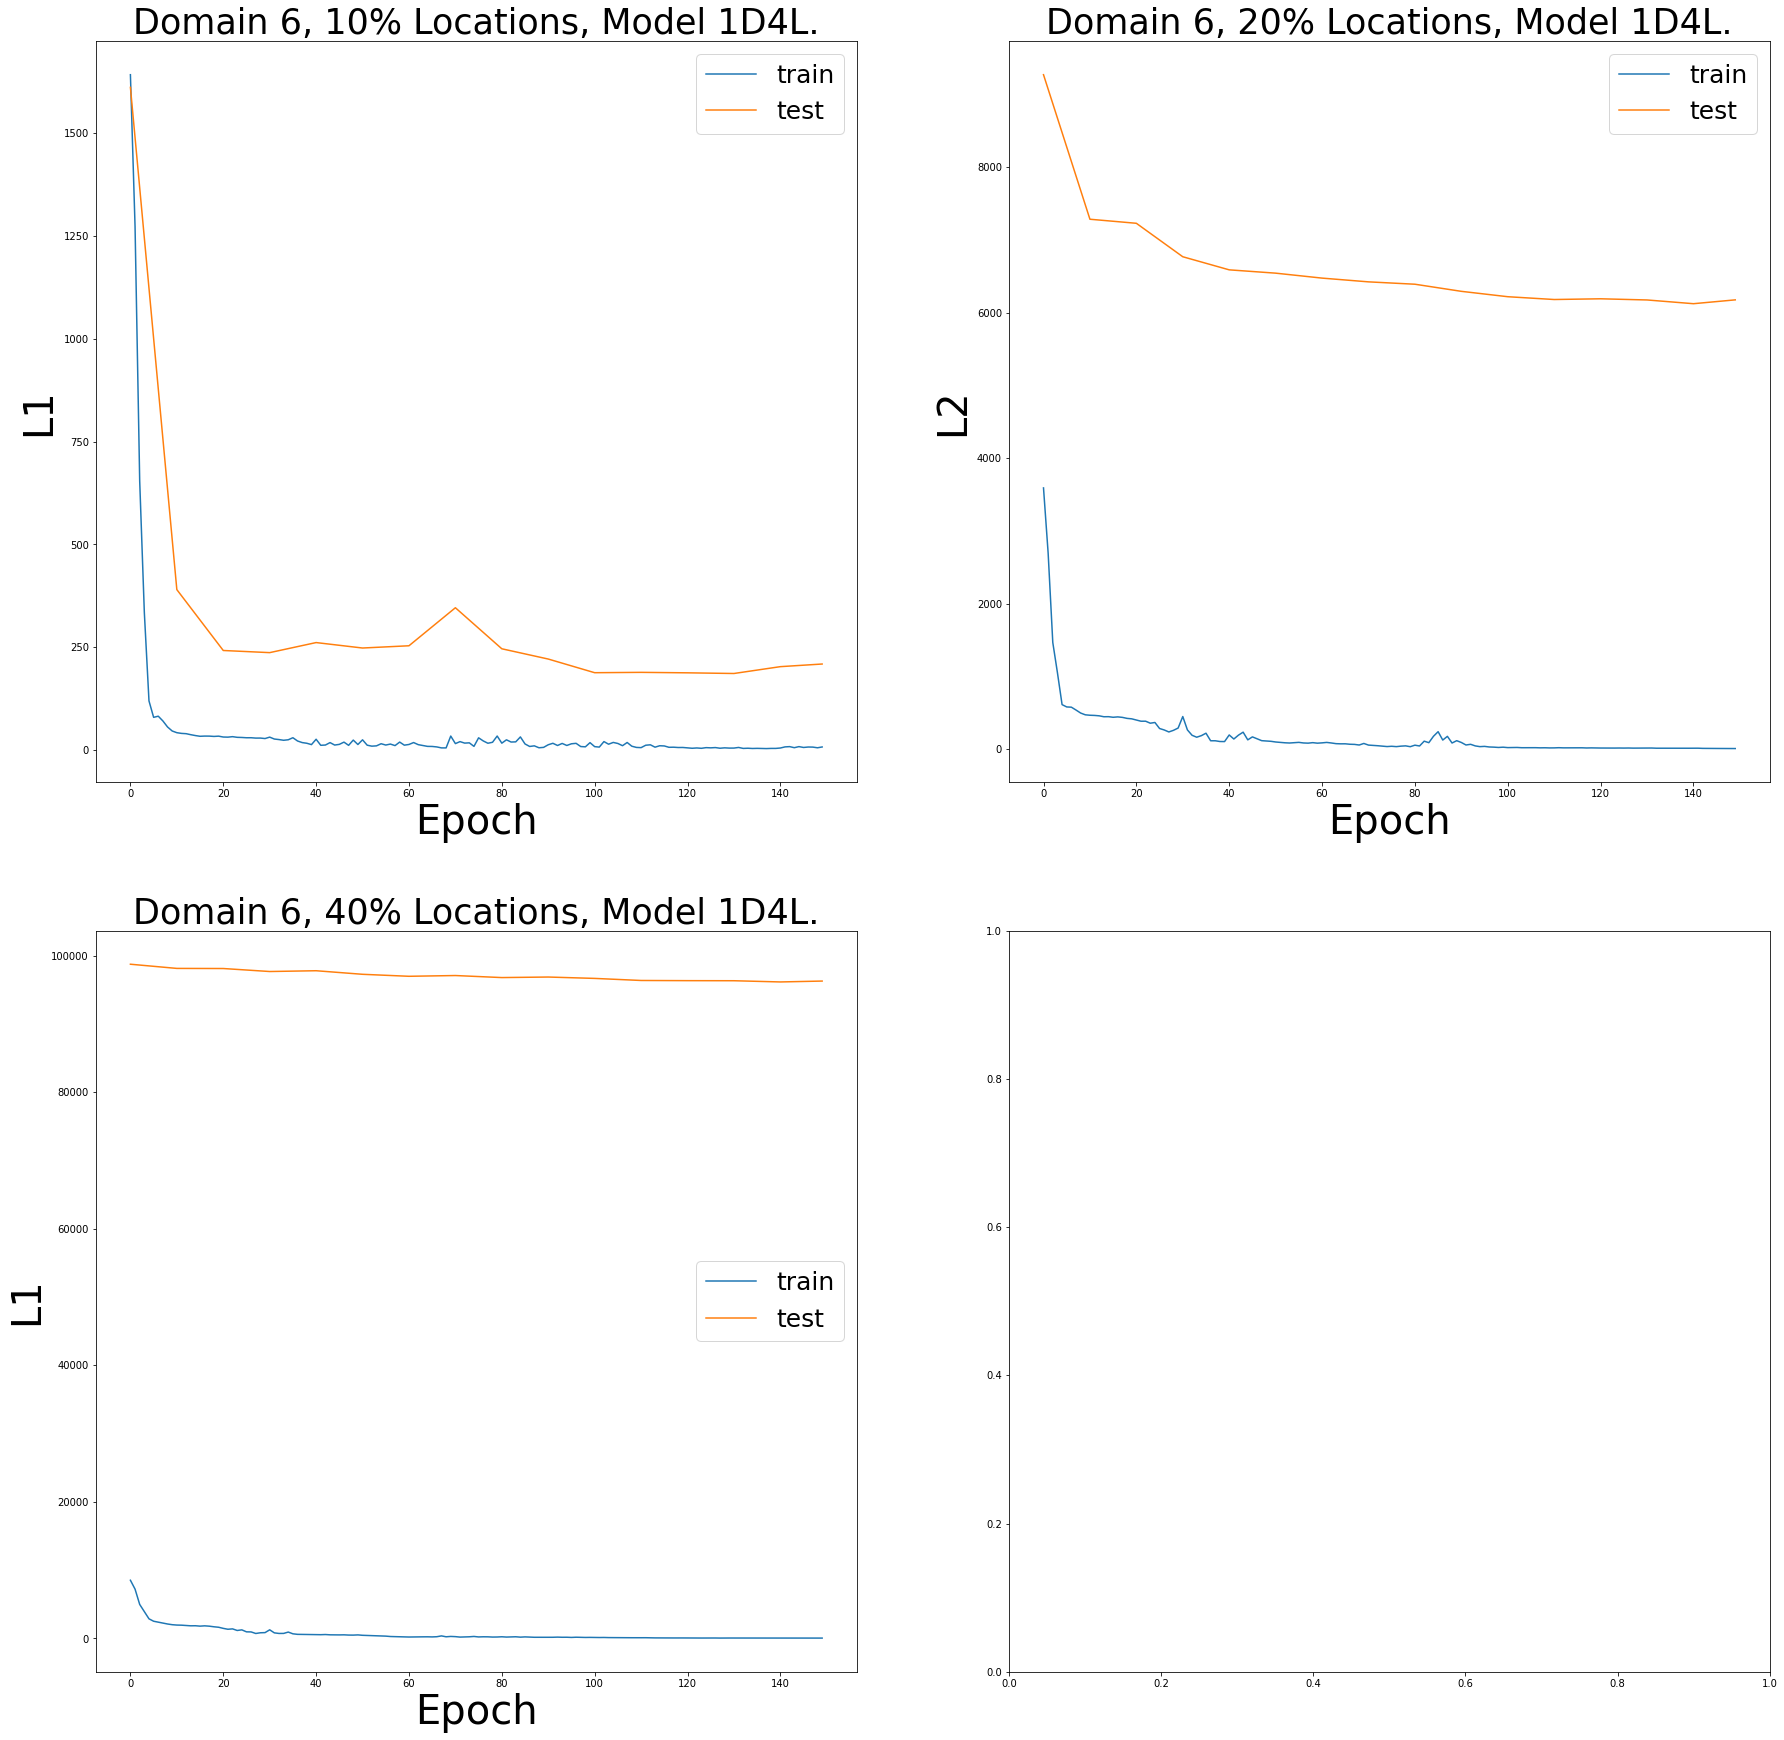

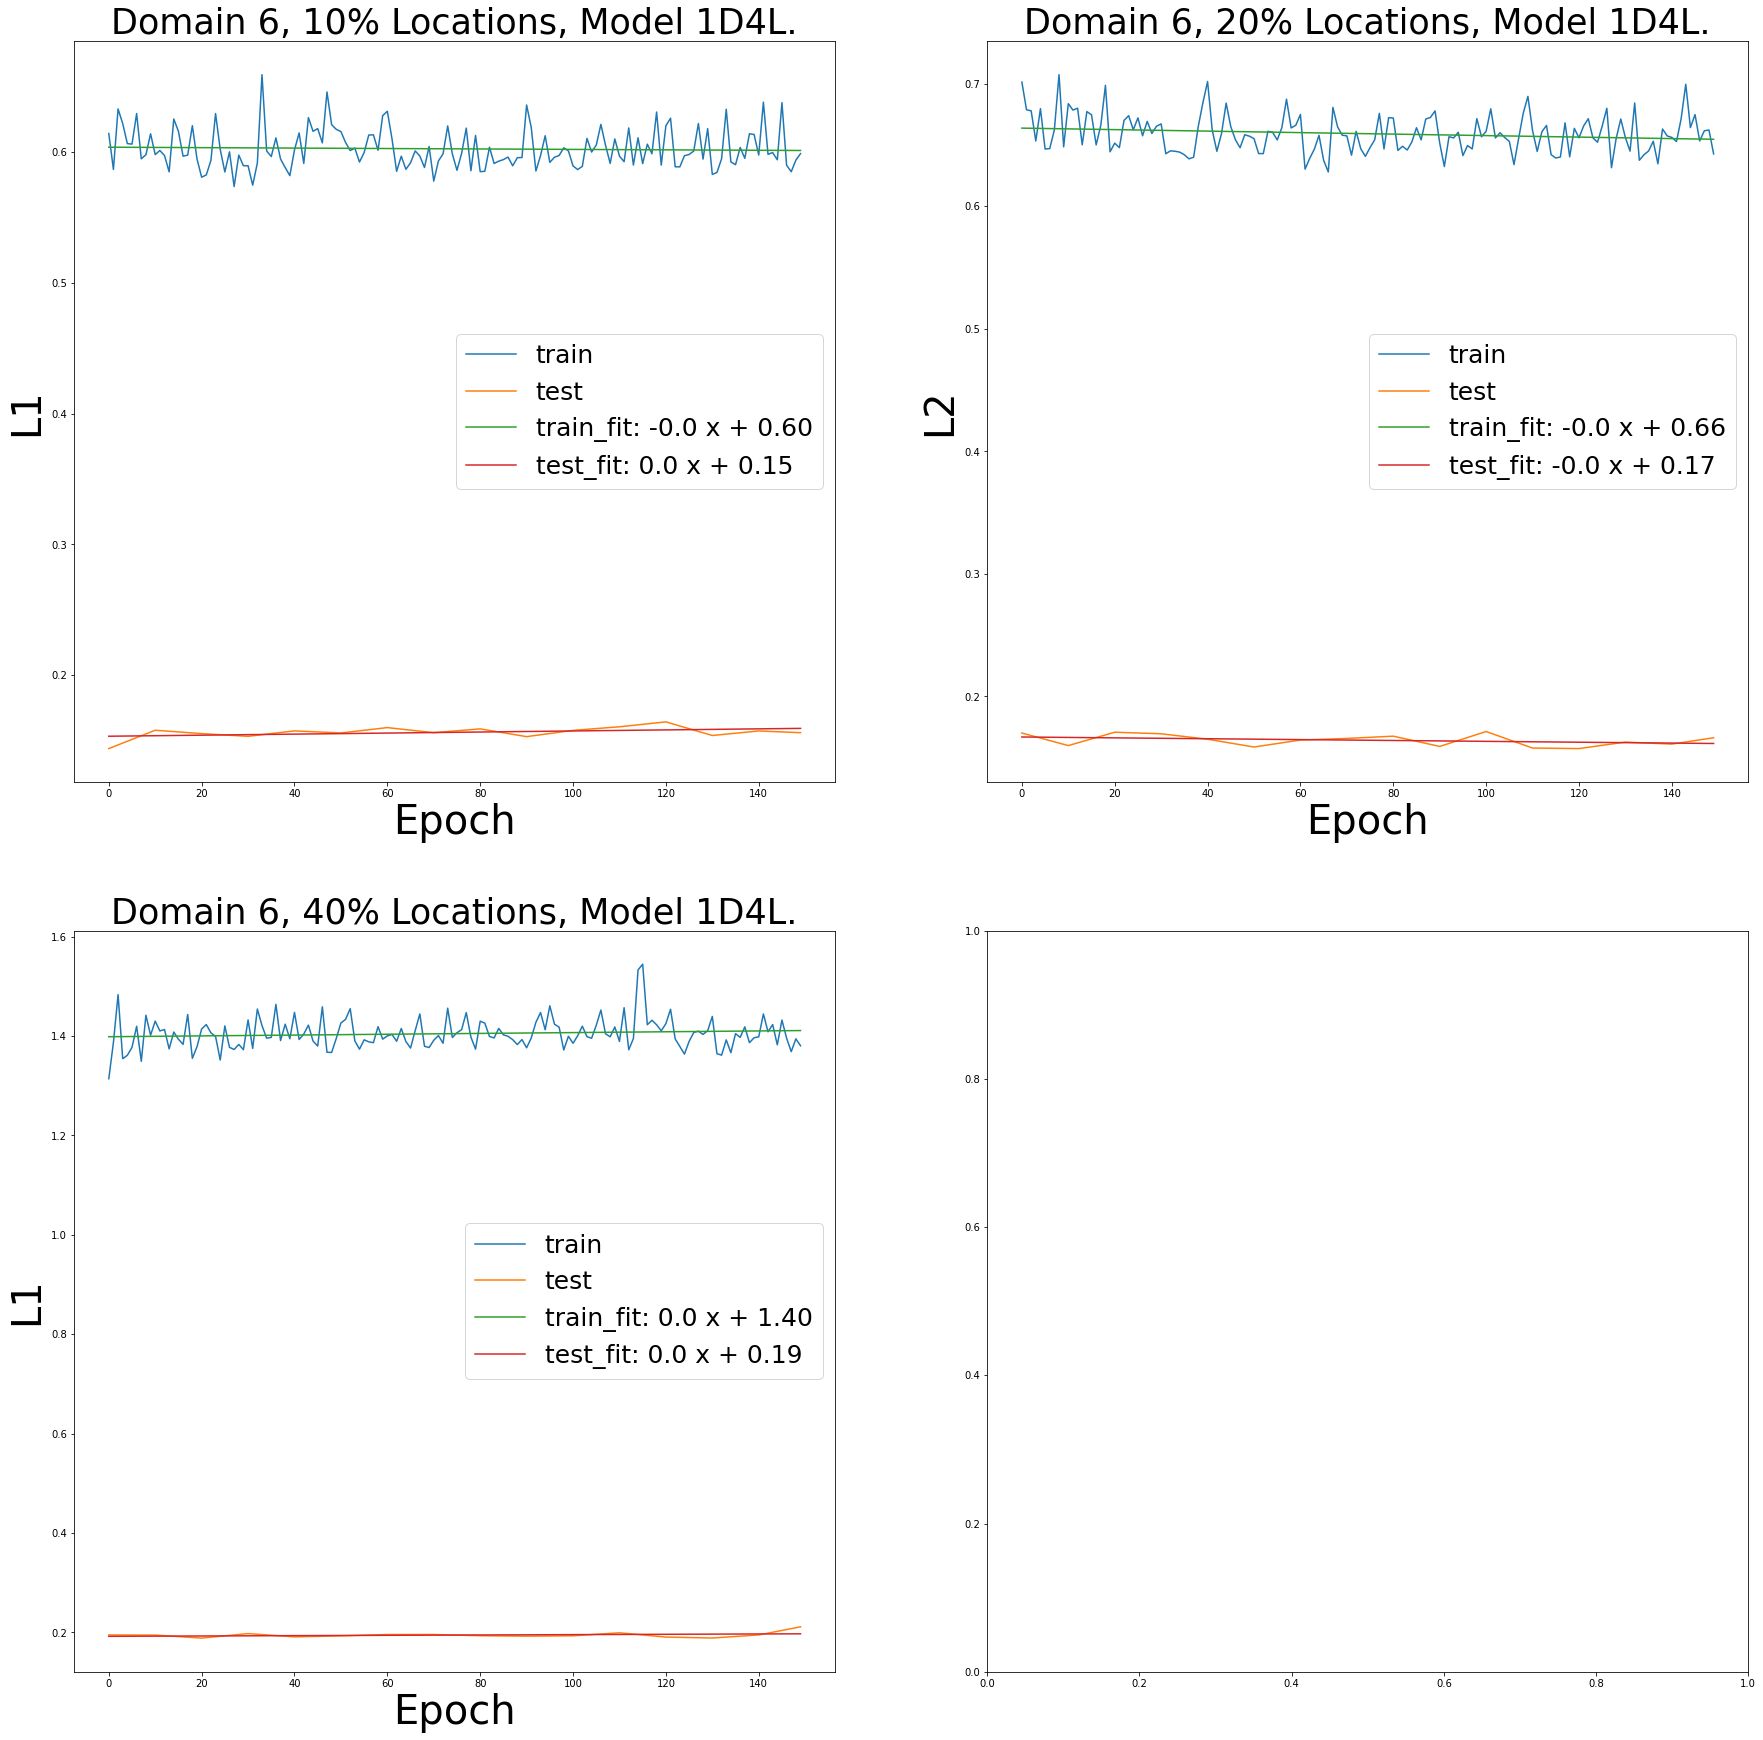

In [36]:
test8_10, train8_10, time8_10 = getAETrainRes("MeanHist", 10, 150, "1D4L", 8)
test8_20, train8_20, time8_20 = getAETrainRes("MeanHist", 20, 150, "1D4L", 8)
test8_40, train8_40, time8_40 = getAETrainRes("MeanHist", 40, 150, "1D4L", 8)
test8_80, train8_80, time8_80 = getAETrainRes("MeanHist", 80, 150, "1D4L", 8)

trainResAll = [train8_10, train8_20, train8_40, train8_80]
testResAll = [test8_10, test8_20, test8_40, test8_80]
timeAll = [time8_10, time8_20, time8_40, time8_80]
percentages = [10, 20, 40, 80]
EPOCH = 150

totalDuration, totalTrainingTime, totalTestingTime = getMeanDurationResults(trainResAll, testResAll, timeAll, percentages, "1D4L", "8")
print("Mean Total Training Duration = {}, Time per Epoch = {}, Mean Train Duration = {}, Mean Testing Duration = {}".format(totalDuration, totalDuration / EPOCH, totalTrainingTime, totalTestingTime))
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D4L", "Loss", 2, 2)
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D4L", "Time", 2, 2)

###---###
test6_10, train6_10, time6_10 = getAETrainRes("MeanHist", 10, 150, "1D4L", 6)
test6_20, train6_20, time6_20 = getAETrainRes("MeanHist", 20, 150, "1D4L", 6)
test6_40, train6_40, time6_40 = getAETrainRes("MeanHist", 40, 150, "1D4L", 6)

trainResAll = [train6_10, train6_20, train6_40]
testResAll = [test6_10, test6_20, test6_40]
percentages = [10, 20, 40]
EPOCH = 150

totalDuration, totalTrainingTime, totalTestingTime = getMeanDurationResults(trainResAll, testResAll, timeAll, percentages, "1D4L", "6")
print("Mean Total Training Duration = {}, Time per Epoch = {}, Mean Train Duration = {}, Mean Testing Duration = {}".format(totalDuration, totalDuration / EPOCH, totalTrainingTime, totalTestingTime))
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D4L", "Loss", 2, 2)
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D4L", "Time", 2, 2)

# 1D - 0 Linear Layers

Subdomain 8 - Model 1D0L - Percent 20 - Total Training Time = 151.299528 - Mean Training Time = 0.9385759115219117 and Mean Testing Time = 0.3164433687925339
Subdomain 8 - Model 1D0L - Percent 40 - Total Training Time = 192.938876 - Mean Training Time = 1.205663644472758 and Mean Testing Time = 0.41271112859249115
Subdomain 8 - Model 1D0L - Percent 60 - Total Training Time = 441.82978 - Mean Training Time = 2.776418967247009 and Mean Testing Time = 1.137165904045105
Subdomain 8 - Model 1D0L - Percent 80 - Total Training Time = 379.760297 - Mean Training Time = 2.392810901006063 and Mean Testing Time = 0.8903852552175522
Mean Total Training Duration = 291.45712025, Time per Epoch = 1.9430474683333334, Mean Train Duration = 1.8283673560619356, Mean Testing Duration = 0.6891764141619205
<function subPlotLoss at 0x116e3f1f0>


<ipython-input-40-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10a1065e0>


<ipython-input-40-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Subdomain 6 - Model 1D0L - Percent 20 - Total Training Time = 150.383332 - Mean Training Time = 0.933467132250468 and Mean Testing Time = 0.3039817363023758
Subdomain 6 - Model 1D0L - Percent 40 - Total Training Time = 315.27467 - Mean Training Time = 1.9801553471883138 and Mean Testing Time = 0.7826368659734726
Subdomain 6 - Model 1D0L - Percent 60 - Total Training Time = 587.714124 - Mean Training Time = 3.71120254834493 and Mean Testing Time = 1.4281091392040253
Subdomain 6 - Model 1D0L - Percent 80 - Total Training Time = 582.928116 - Mean Training Time = 3.674717351595561 and Mean Testing Time = 1.468474730849266
Mean Total Training Duration = 409.0750605, Time per Epoch = 2.72716707, Mean Train Duration = 2.574885594844818, Mean Testing Duration = 0.9958006180822849
<function subPlotLoss at 0x116e3f1f0>


<ipython-input-40-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function subPlotTrainingTime at 0x10a1065e0>


<ipython-input-40-713bfe57cb0f>:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


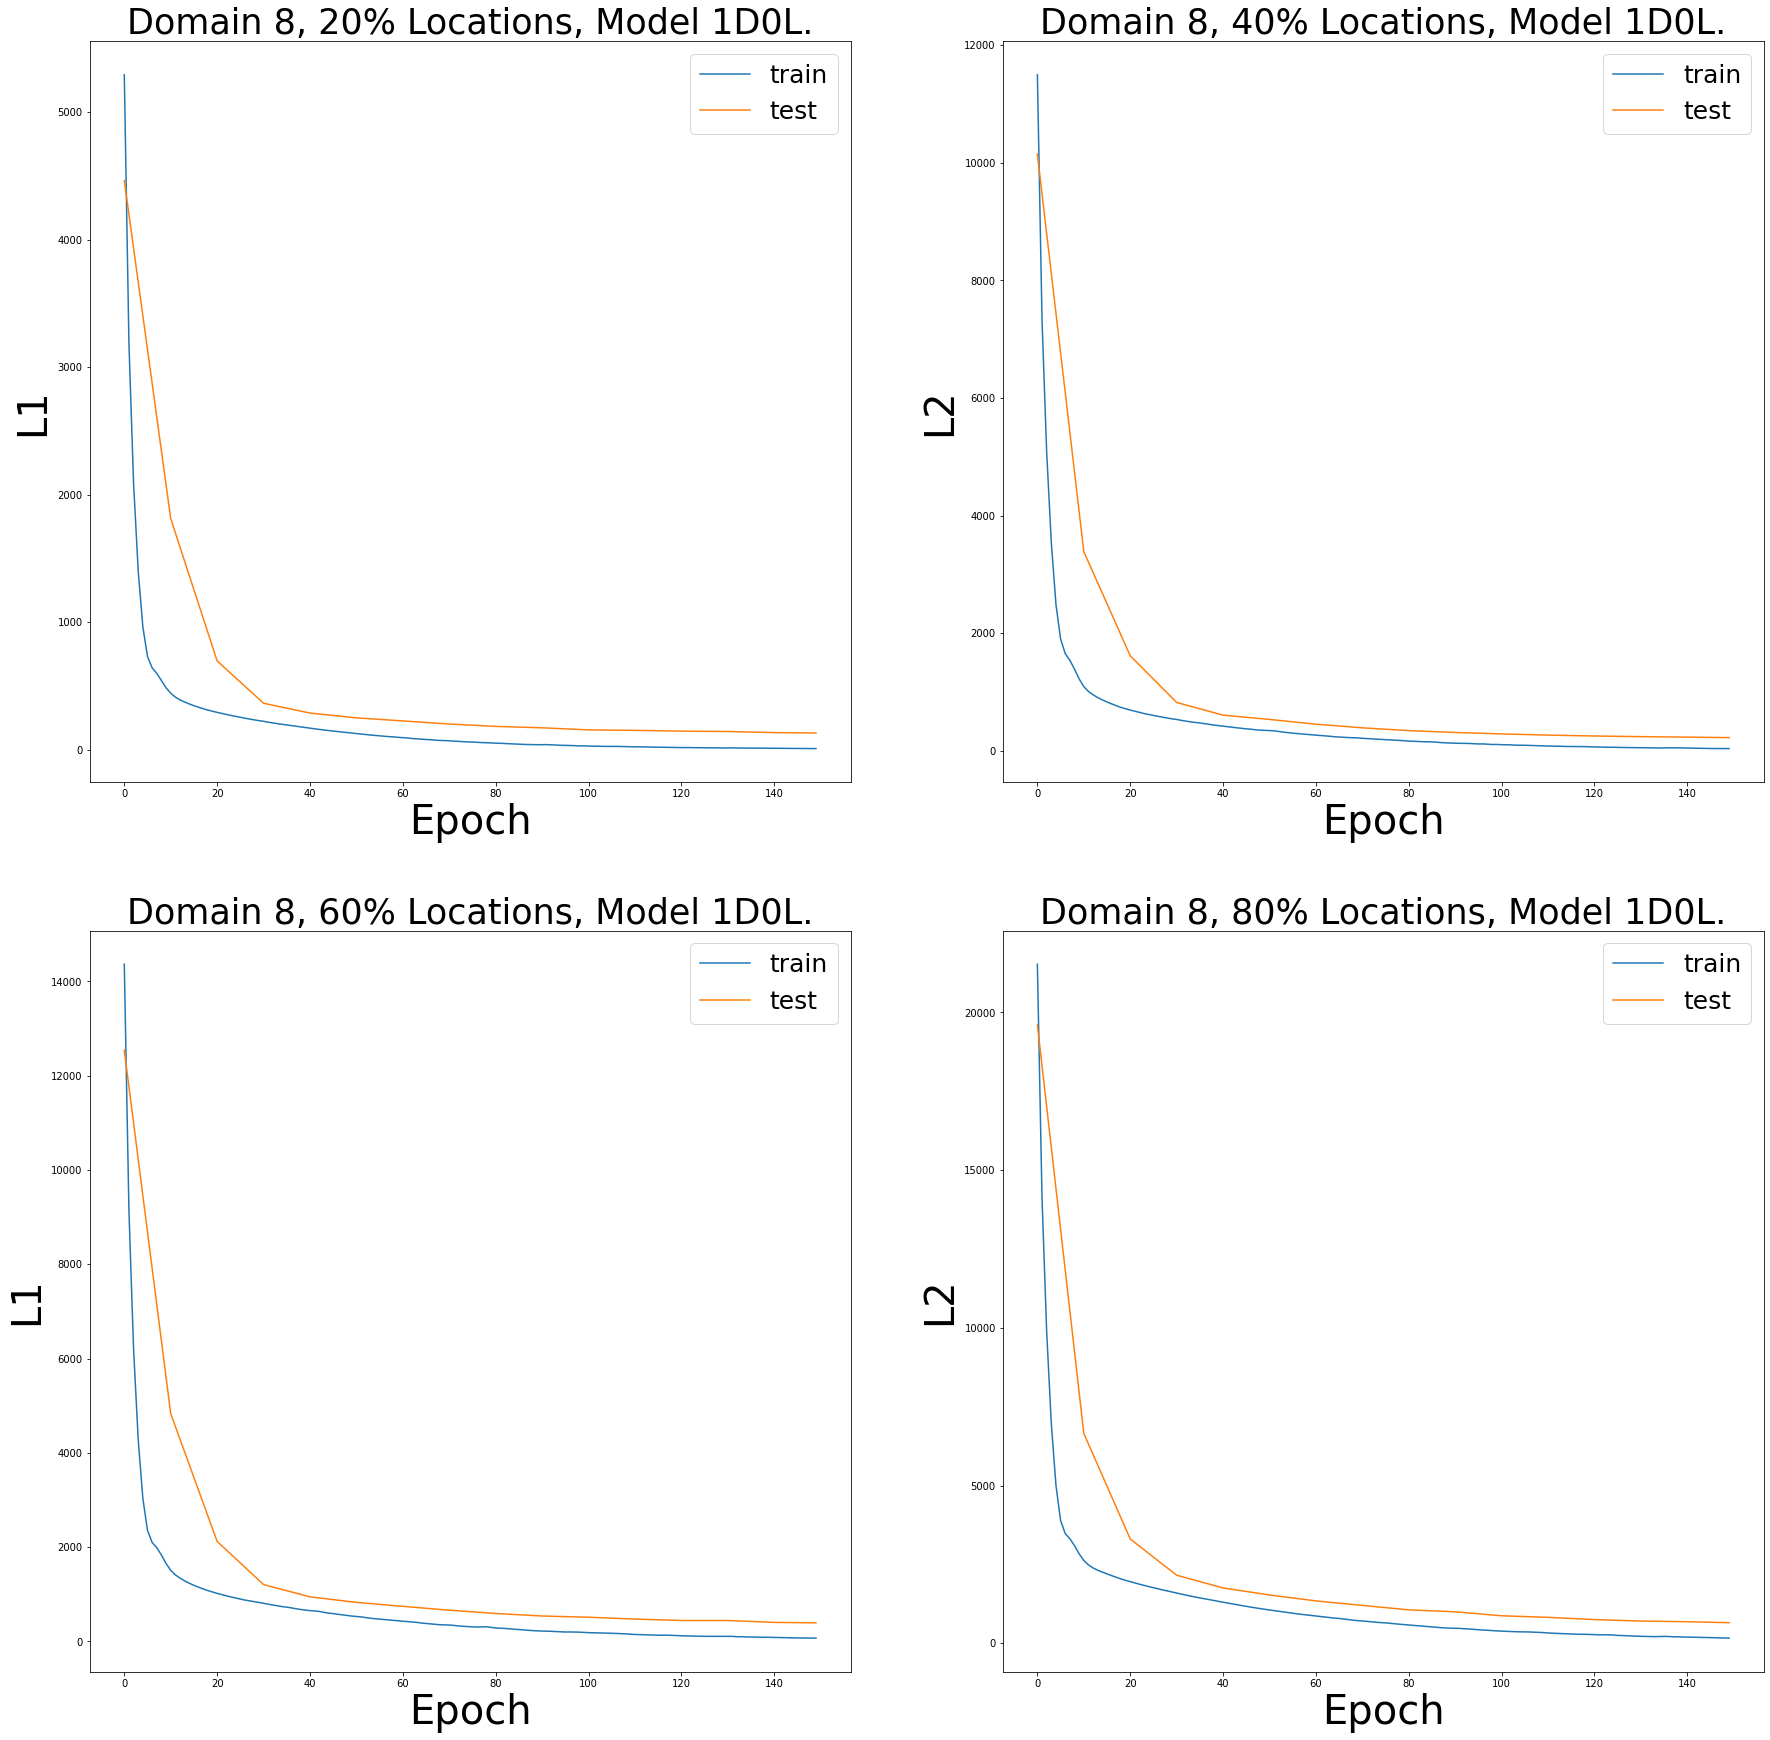

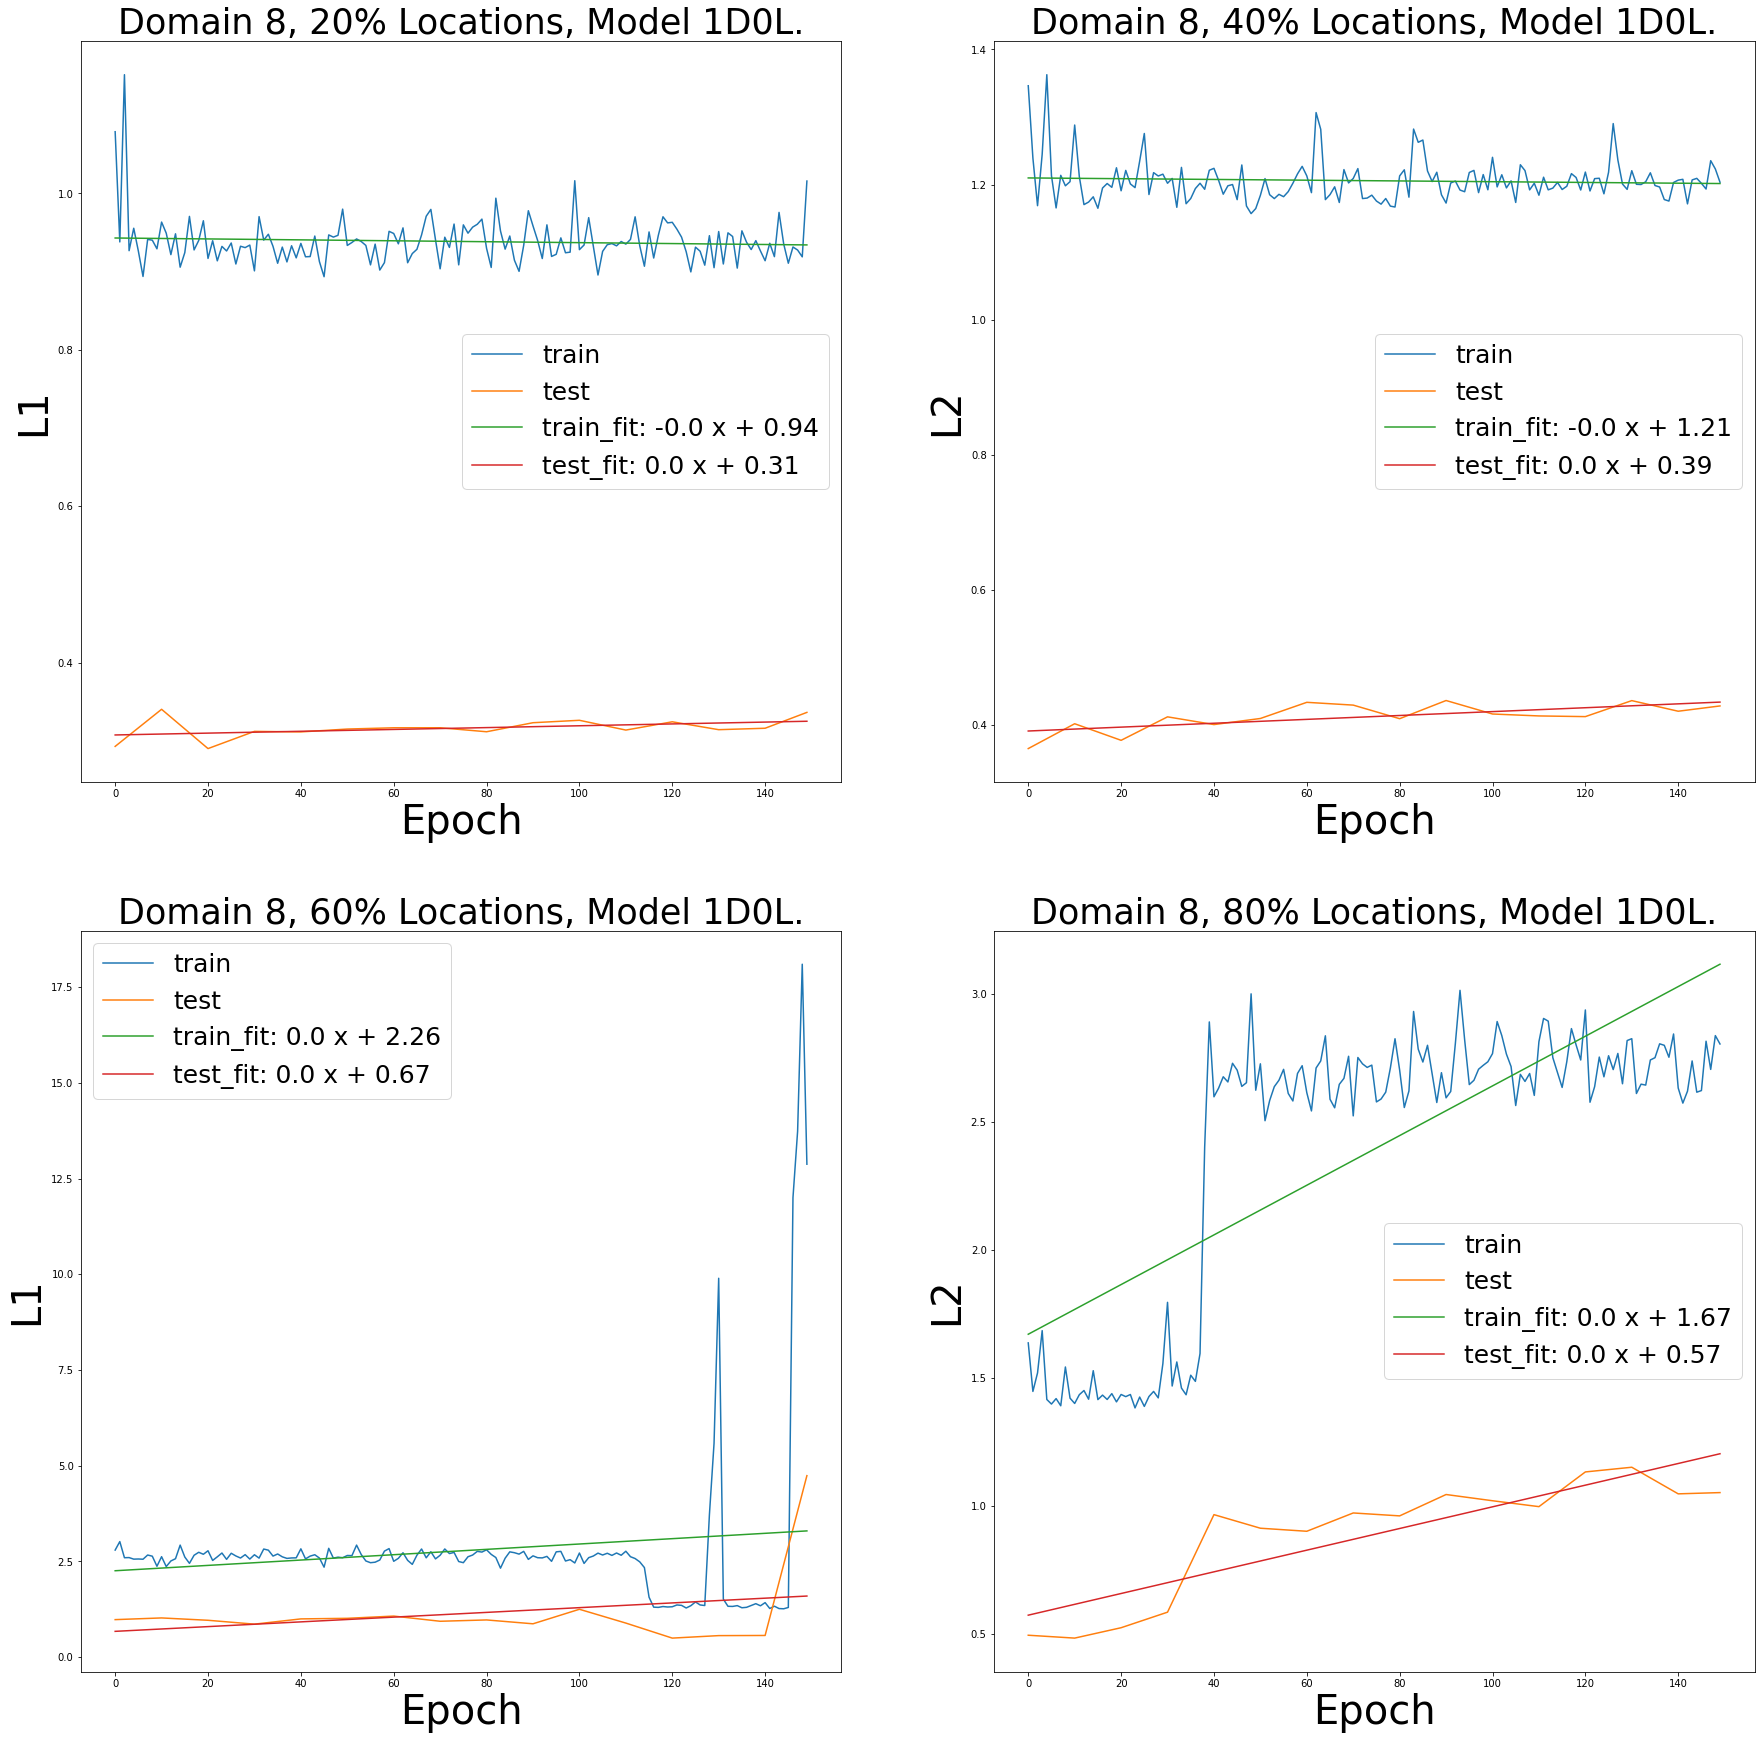

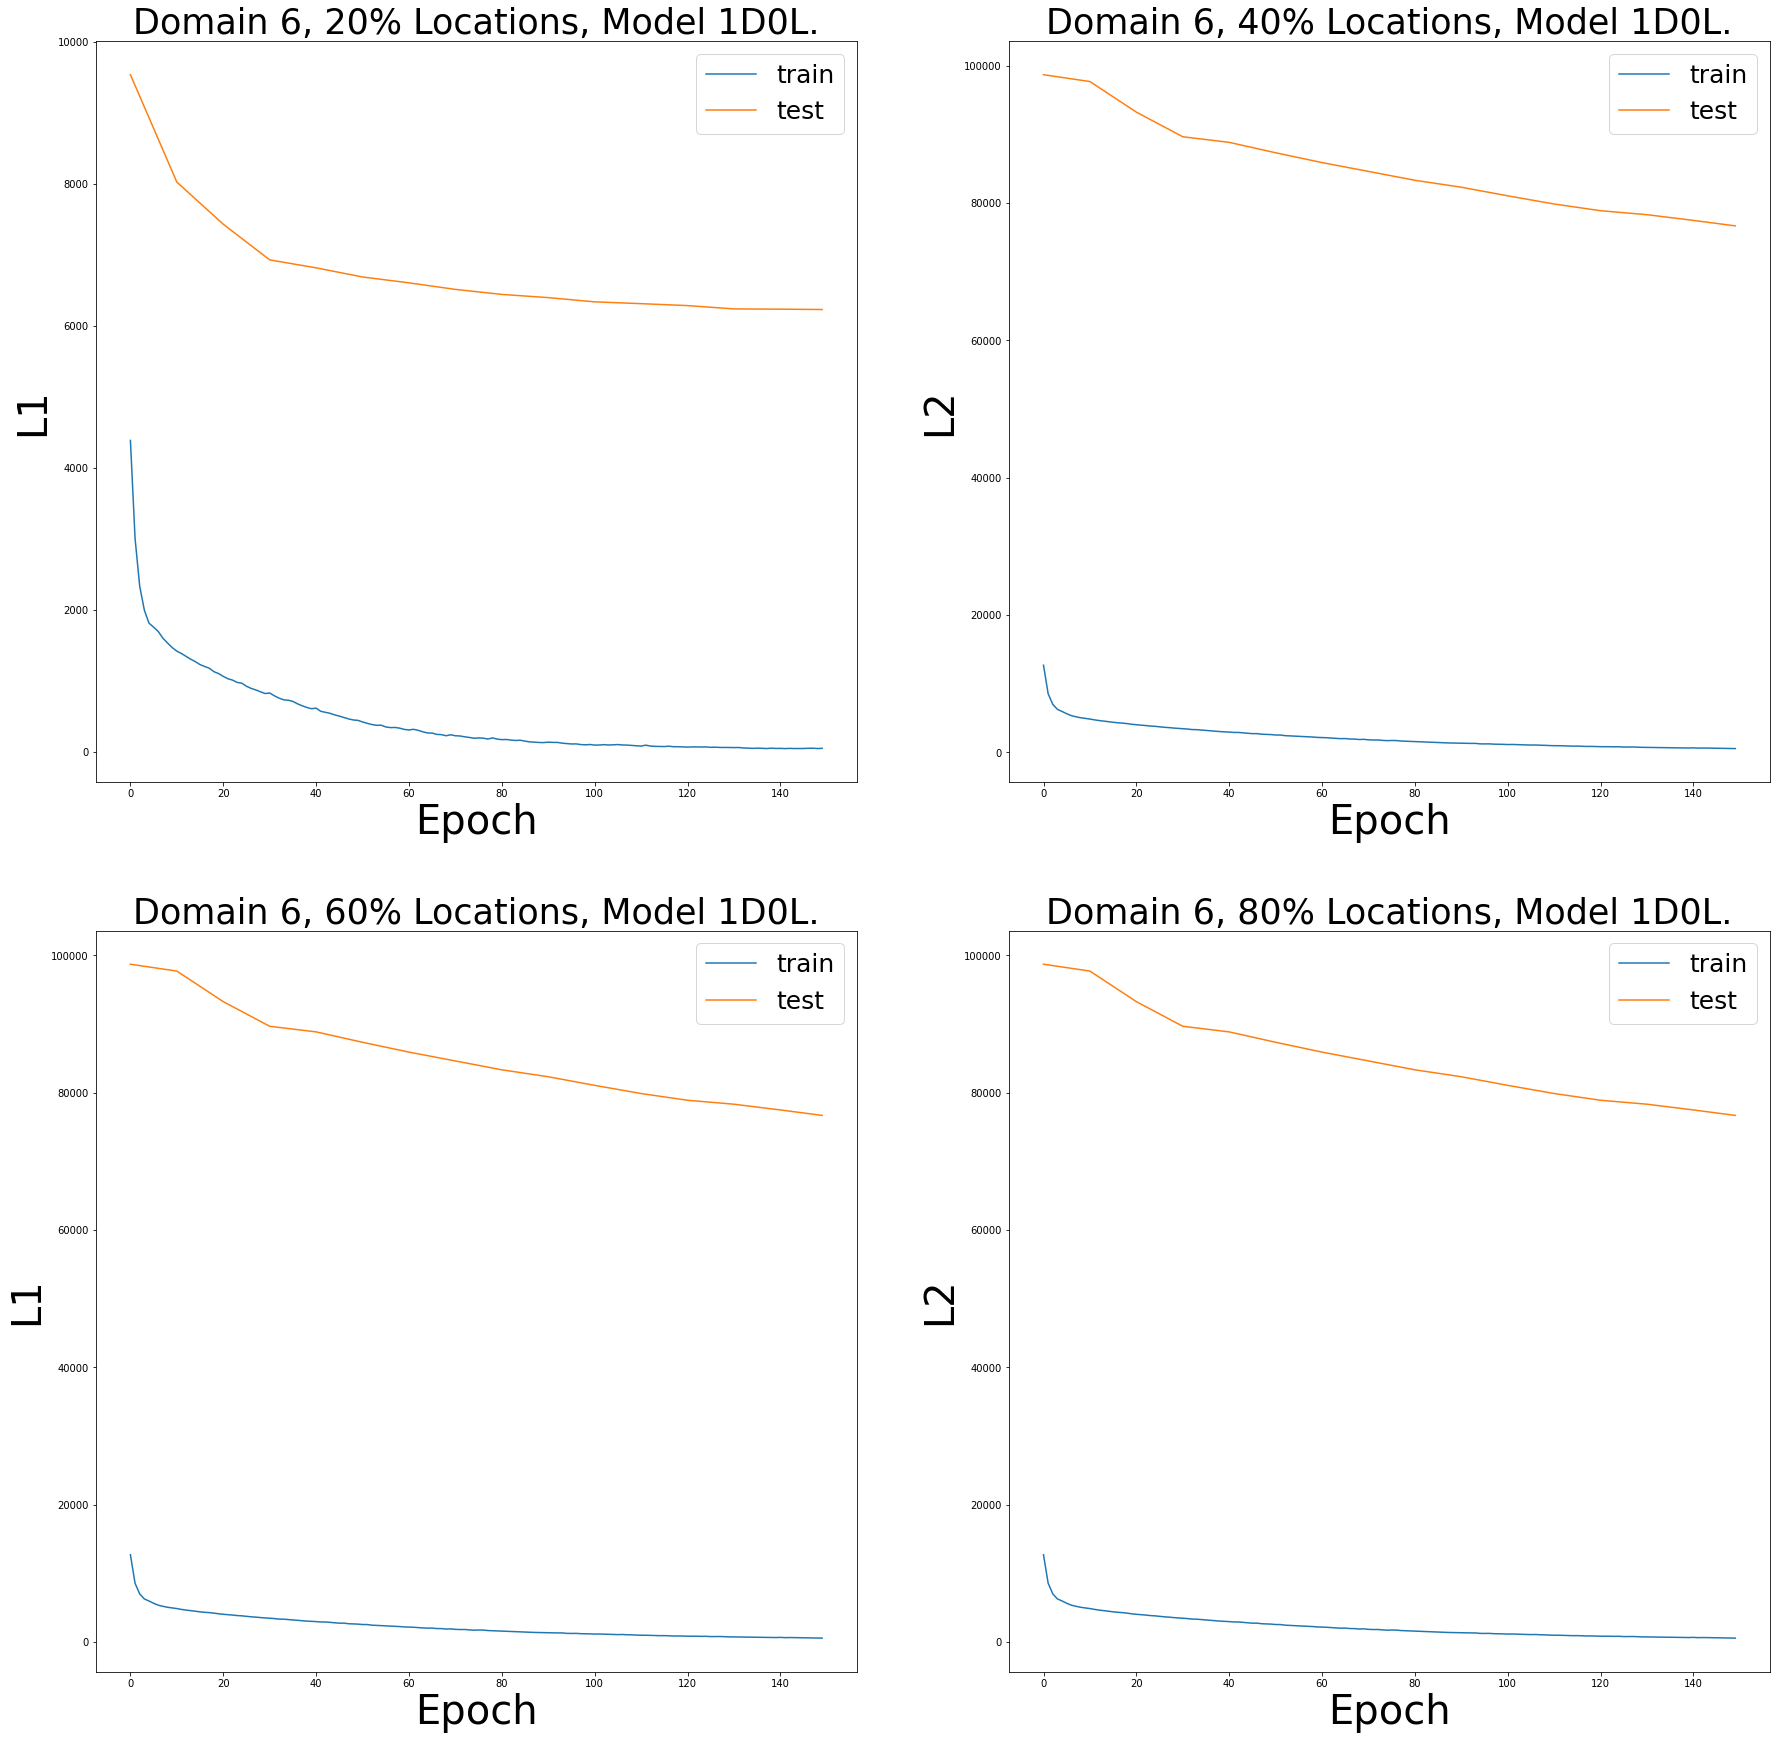

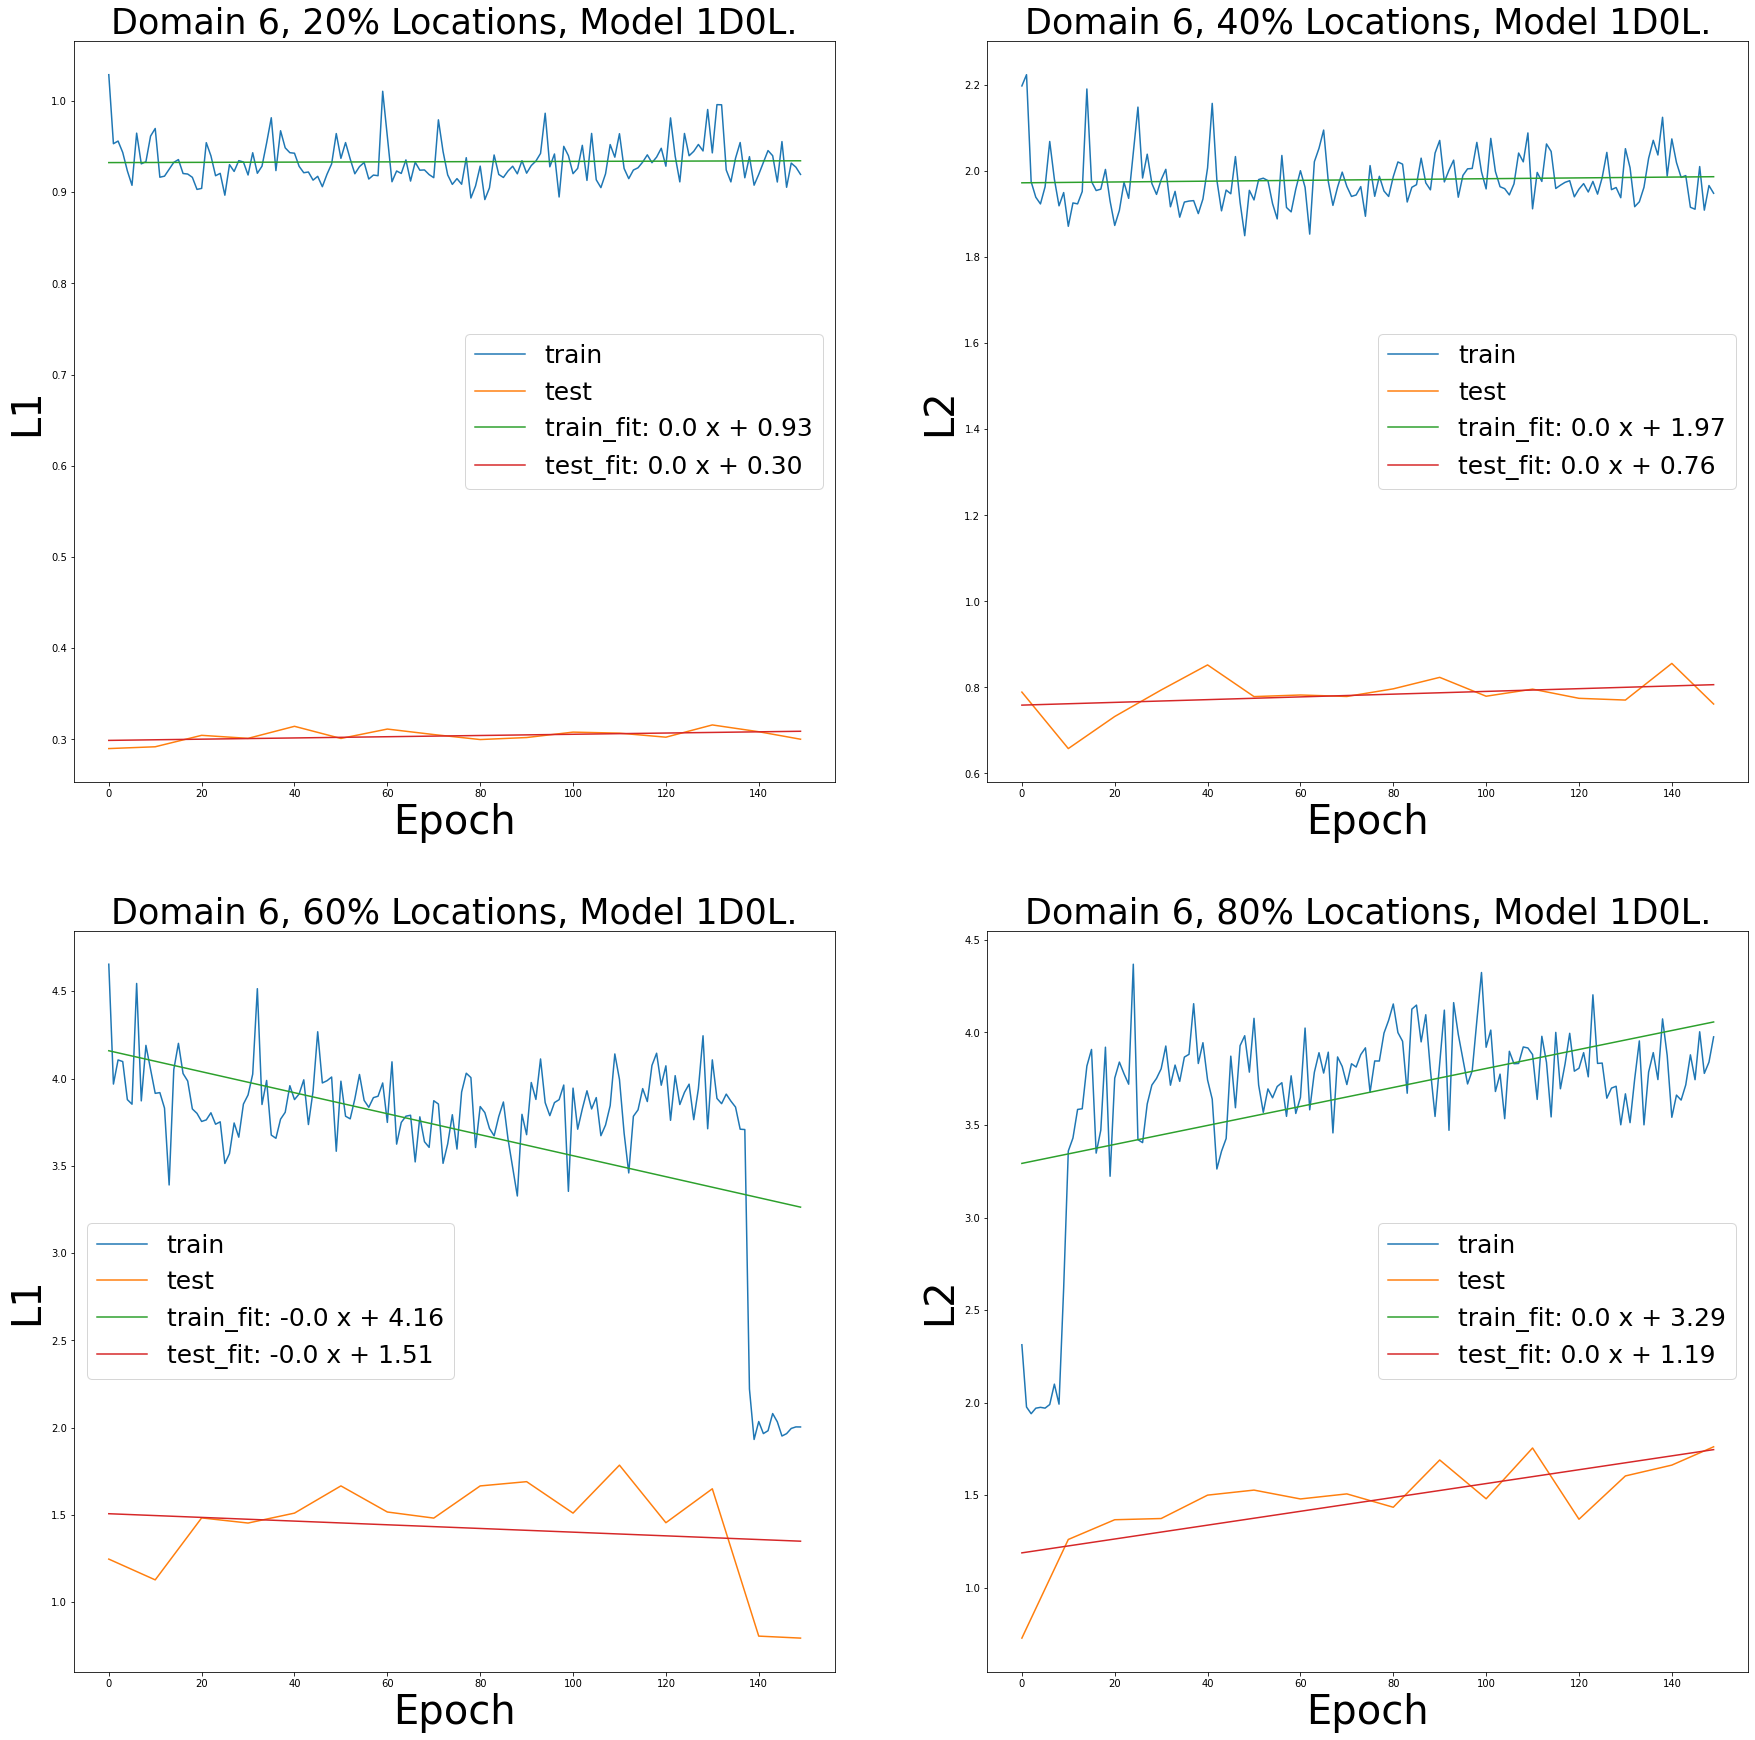

In [41]:
test8_20, train8_20, time8_20 = getAETrainRes("MeanHist", 20, 150, "1D0L", 8)
test8_40, train8_40, time8_40 = getAETrainRes("MeanHist", 40, 150, "1D0L", 8)
test8_60, train8_60, time8_60 = getAETrainRes("MeanHist", 60, 150, "1D0L", 8)
test8_80, train8_80, time8_80 = getAETrainRes("MeanHist", 80, 150, "1D0L", 8)

trainResAll = [train8_20,train8_40, train8_60, train8_80]
testResAll = [test8_20, test8_40, test8_60, test8_80]
timeAll = [time8_20, time8_40, time8_60, time8_80]
percentages = [20, 40, 60, 80]
EPOCH = 150

totalDuration, totalTrainingTime, totalTestingTime = getMeanDurationResults(trainResAll, testResAll, timeAll, percentages, "1D0L", "8")
print("Mean Total Training Duration = {}, Time per Epoch = {}, Mean Train Duration = {}, Mean Testing Duration = {}".format(totalDuration, totalDuration / EPOCH, totalTrainingTime, totalTestingTime))
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D0L", "Loss", 2, 2)
createPlots(trainResAll, testResAll, percentages, "150", "8", "1D0L", "Time", 2, 2)

###---###
test6_20, train6_20, time6_20 = getAETrainRes("MeanHist", 20, 150, "1D0L", 6)
test6_40, train6_40, time6_40 = getAETrainRes("MeanHist", 40, 150, "1D0L", 6)
test6_60, train6_60, time6_60 = getAETrainRes("MeanHist", 60, 150, "1D0L", 6)
test6_80, train6_80, time6_80 = getAETrainRes("MeanHist", 80, 150, "1D0L", 6)

trainResAll = [train6_20, train6_40, train6_60, train6_80]
testResAll = [test6_20, test6_40, test6_60, test6_80]
timeAll = [time6_20, time6_40, time6_60, time6_80]
percentages = [20, 40, 60, 80]
EPOCH = 150

totalDuration, totalTrainingTime, totalTestingTime = getMeanDurationResults(trainResAll, testResAll, timeAll, percentages, "1D0L", "6")
print("Mean Total Training Duration = {}, Time per Epoch = {}, Mean Train Duration = {}, Mean Testing Duration = {}".format(totalDuration, totalDuration / EPOCH, totalTrainingTime, totalTestingTime))
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D0L", "Loss", 2, 2)
createPlots(trainResAll, testResAll, percentages, "150", "6", "1D0L", "Time", 2, 2)